In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

In [3]:
steps = 10_000
epsilon_values = [0.01, 0.05, 0.1, 0.4]
num_runs = 1

In [4]:
def get_probabilities():
    probs = [
        np.random.normal(0, 5),
        np.random.normal(-0.5, 12),
        np.random.normal(2, 3.9),
        np.random.normal(-0.5, 7),
        np.random.normal(-1.2, 8),
        np.random.normal(-3, 7),
        np.random.normal(-10, 20),
        np.random.normal(-0.5, 1),
        np.random.normal(-1, 2),
        np.random.normal(1, 6),
        np.random.normal(0.7, 4),
        np.random.normal(-6, 11),
        np.random.normal(-7, 1),
        np.random.normal(-0.5, 2),
        np.random.normal(-6.5, 1),
        np.random.normal(-3, 6),
        np.random.normal(0, 8),
        np.random.normal(2, 3.9),
        np.random.normal(-9, 12),
        np.random.normal(-1, 6),
        np.random.normal(-4.5, 8)
    ]
    return probs

In [5]:
def update_score_history(score, score_history, machine):
    score_history[machine].append(score)

def get_machine_counts(score_history):
    return [len(machine_scores) for machine_scores in score_history]

def get_current_preds(score_history):
    averages = []
    
    for scores in score_history:
        if len(scores) > 0:
            avg = sum(scores) / len(scores)
        else:
            avg = 0
        averages.append(avg)
    
    return averages

def get_action(epsilon, score_history):
    if random.random() > epsilon:
        current_preds = get_current_preds(score_history)
        best_machine = max(range(len(current_preds)), key=lambda i: current_preds[i])
        return best_machine
    else:
        return random.choice(range(len(score_history)))

def compute_running_average(individual_score_history):
    running_avg = []
    total = 0
    
    for i, value in enumerate(individual_score_history, 1):
        total += value
        running_avg.append(total / i)
    
    return running_avg



def run_sim(steps, epsilon):
    score_history = [[] for _ in range(20)]
    individual_score_history = []
    results = []
    for _ in range(steps):
        machine = get_action(epsilon, score_history)
        value = get_probabilities()[machine]
        update_score_history(value , score_history, machine)
        results.append(get_current_preds(score_history))
        individual_score_history.append(value)

    running_average_history = compute_running_average(individual_score_history)
    transposed_results = list(map(list, zip(*results)))
    return transposed_results, running_average_history
    

In [6]:
def plot_individual_machines(results, label_string):
    plt.figure(figsize=(20, 10))
    
    for machine_id, machine_scores in enumerate(results):
        plt.plot(machine_scores, label=f'Machine {machine_id + 1}')
        
    plt.xlabel('Steps')
    plt.ylabel('Average Score')
    plt.title(label_string)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout()
    plt.ylim(-20, 5)
    
    plt.show()

def plot_running_average_epsilon(full_results, epsilon_values, label_string=""):
    plt.figure(figsize=(20, 10))
    
    for i, running_average_history in enumerate(full_results):
        plt.plot(running_average_history, label=f'Epsilon = {epsilon_values[i]}')
    
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title(f'Running Average of Rewards for Different Epsilon Values {label_string}')
    plt.legend()
    plt.ylim(-4, 4)
    plt.grid(True)
    plt.show()

def plot_running_average_x(full_results, name_string):
    plt.figure(figsize=(20, 10))
    plt.plot(full_results)
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title(f'Running Average of Rewards for {name_string}')
    plt.ylim(-4, 4)
    plt.grid(True)
    plt.show()

def plot_running_average_combined(full_results, epsilon_values, thompson_results):
    plt.figure(figsize=(20, 10))
    
    for i, running_average_history in enumerate(full_results):
        plt.plot(running_average_history, label=f'Epsilon = {epsilon_values[i]}')
    
    plt.plot(thompson_results, label='Thompson Sampling', linestyle='--', color='black', linewidth=2)
    
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Running Average of Rewards for Epsilon-Greedy and Thompson Sampling')
    plt.legend()
    plt.ylim(-4, 4)
    plt.grid(True)
    plt.show()

def plot_quenching_strategies(running_averages, labels):
    plt.figure(figsize=(20, 10))
    
    # Plot each quenching strategy's running average
    for i, avg_history in enumerate(running_averages):
        plt.plot(avg_history, label=labels[i])
    
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Running Average of Rewards for Different Quenching Strategies')
    plt.legend()
    plt.ylim(-4, 4)
    plt.grid(True)
    plt.show()

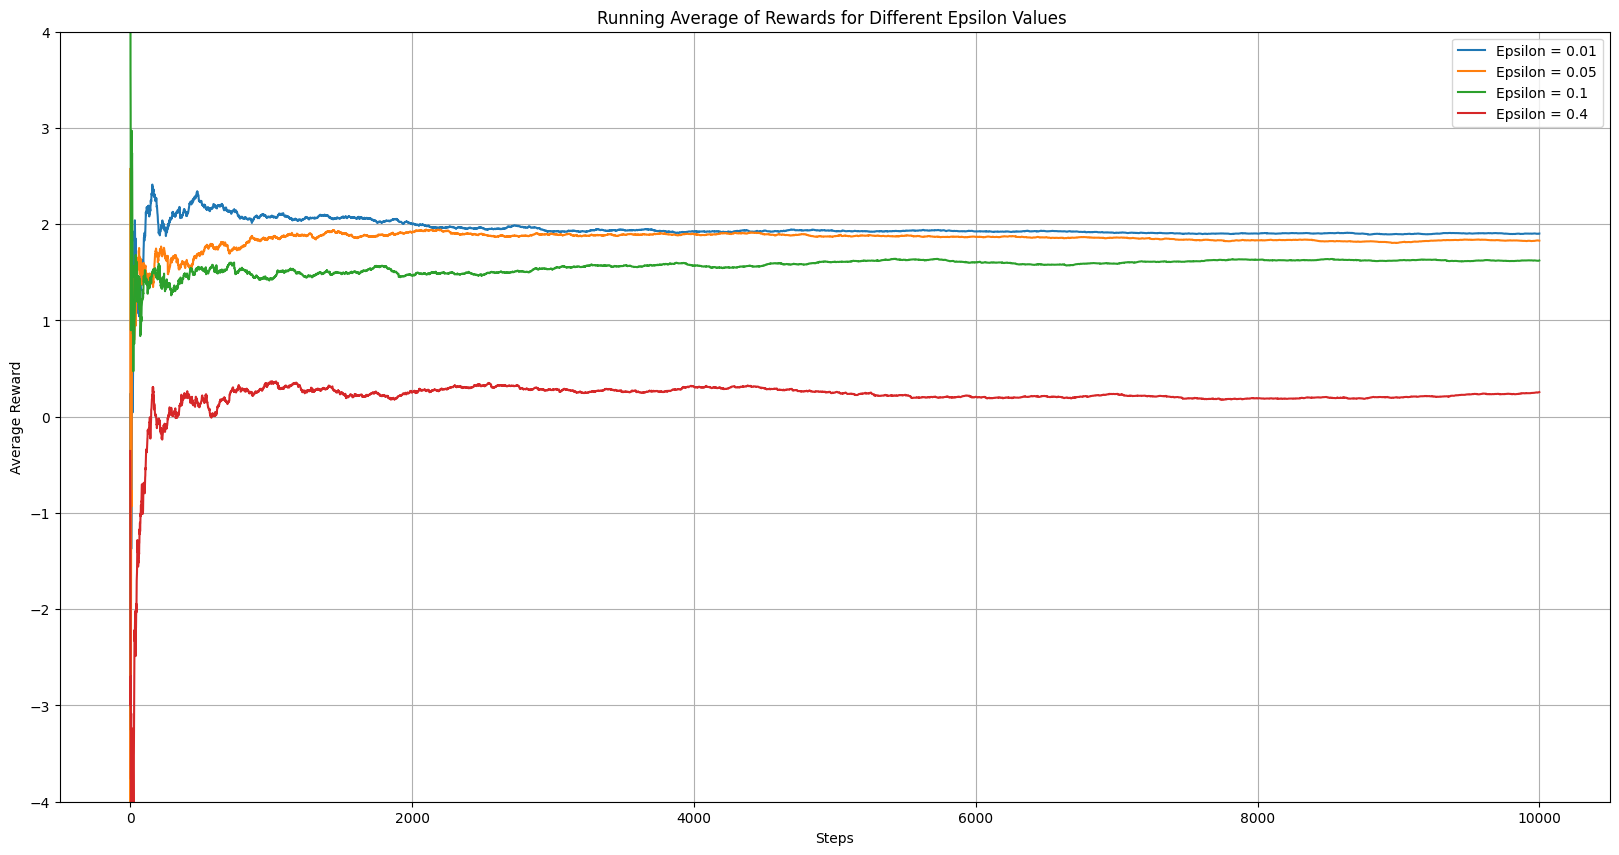

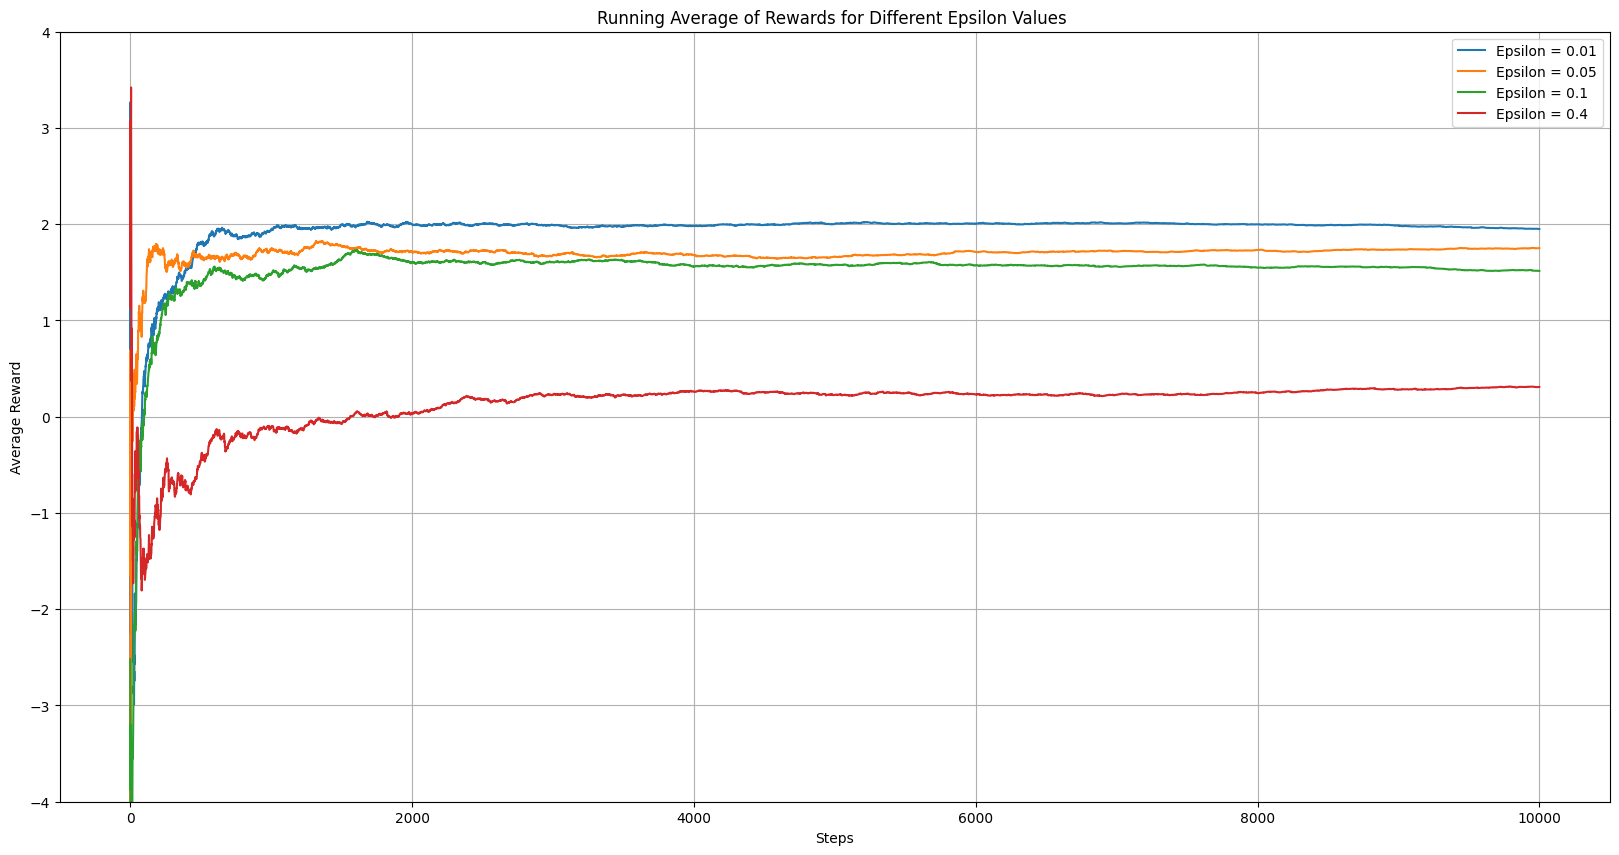

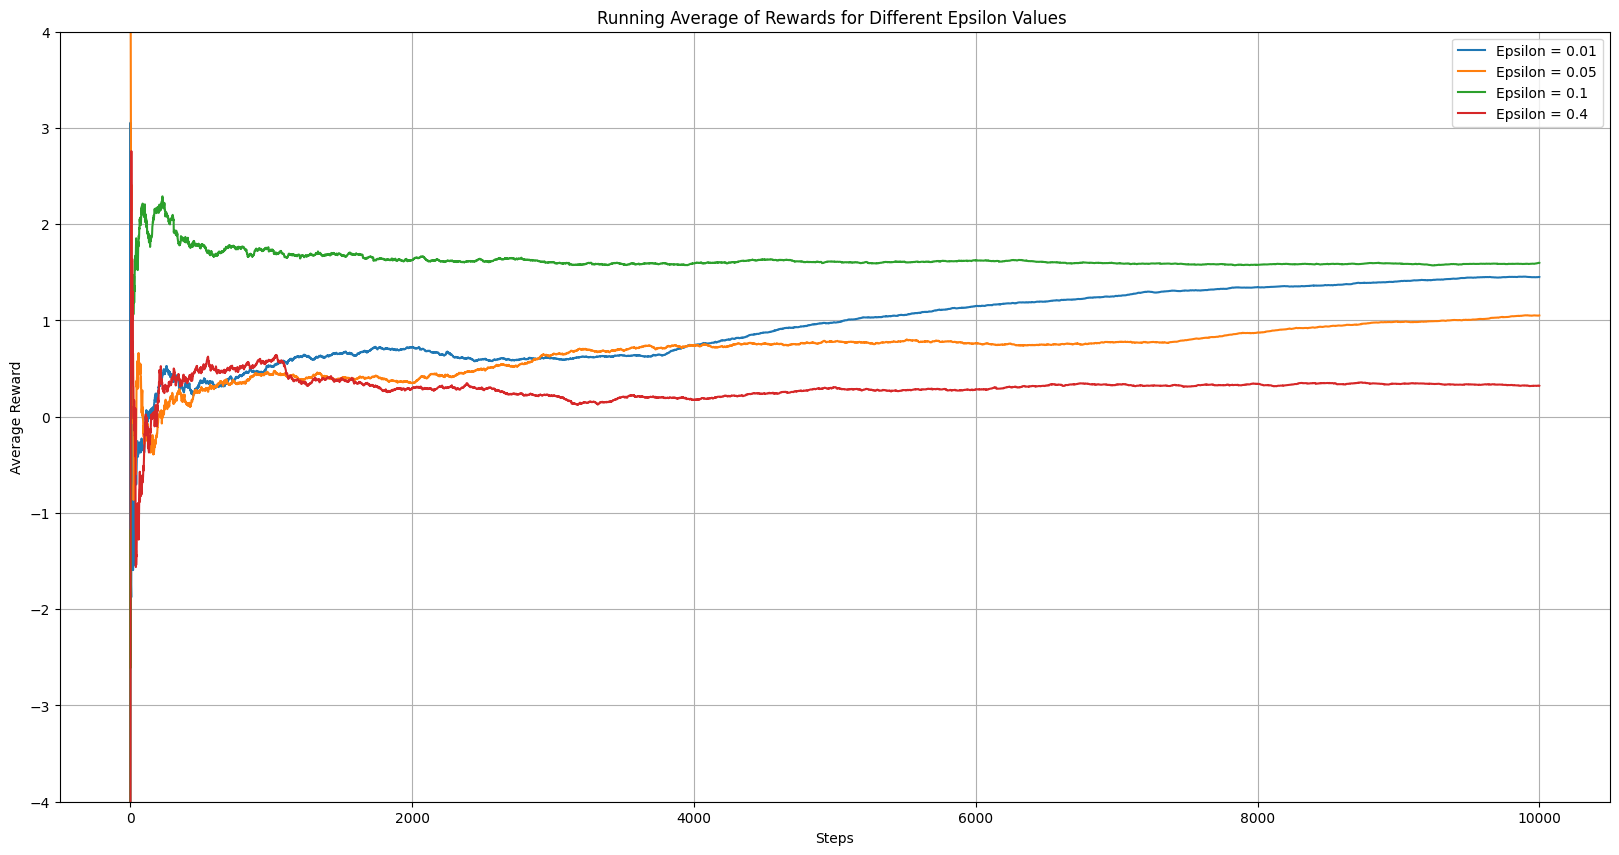

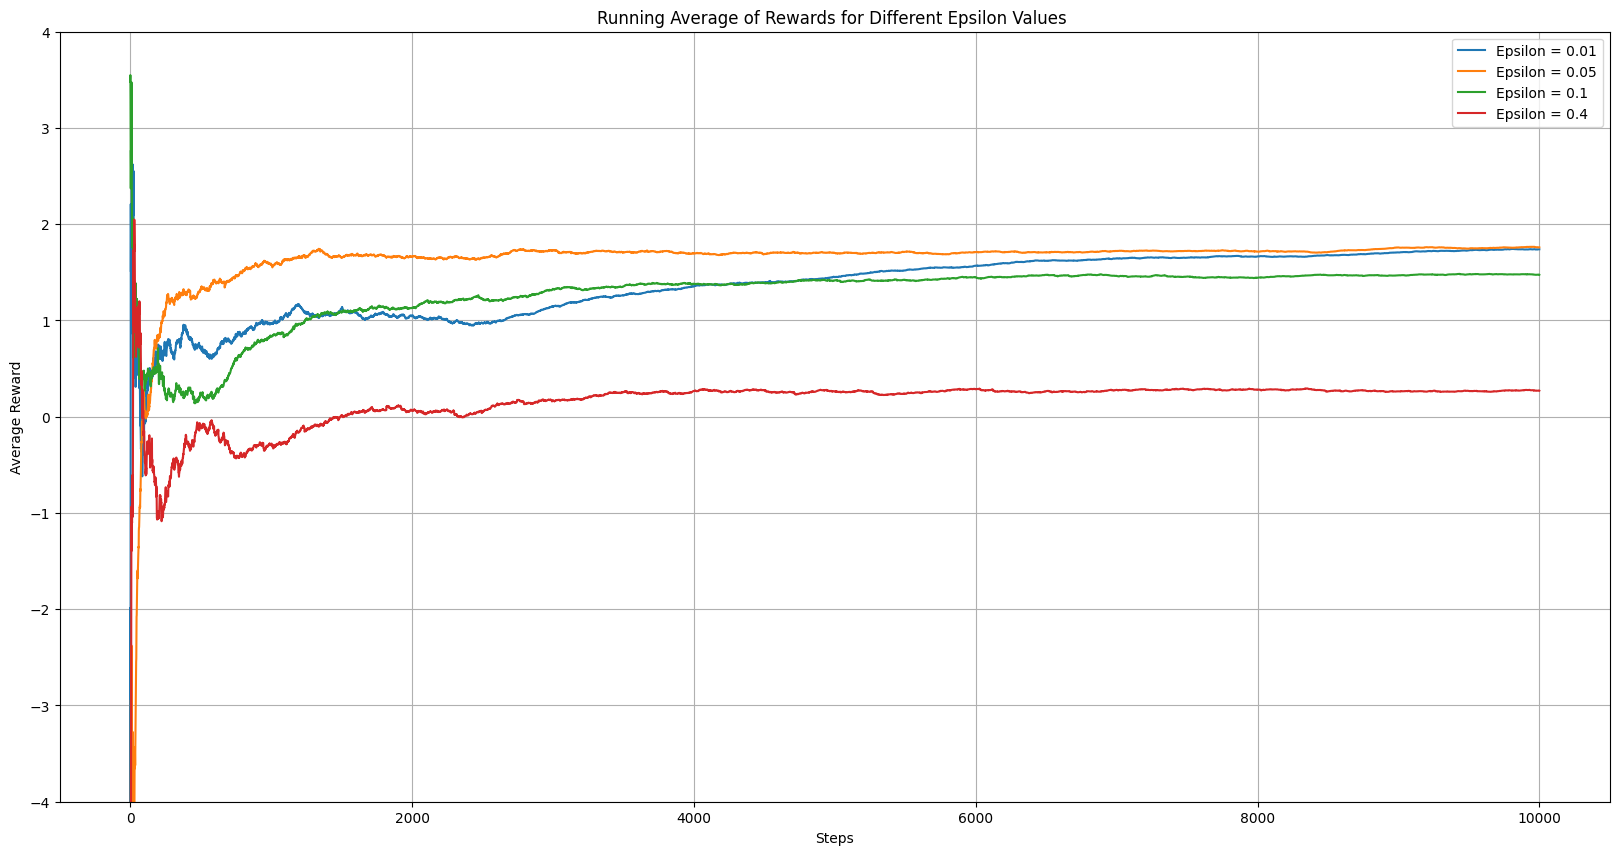

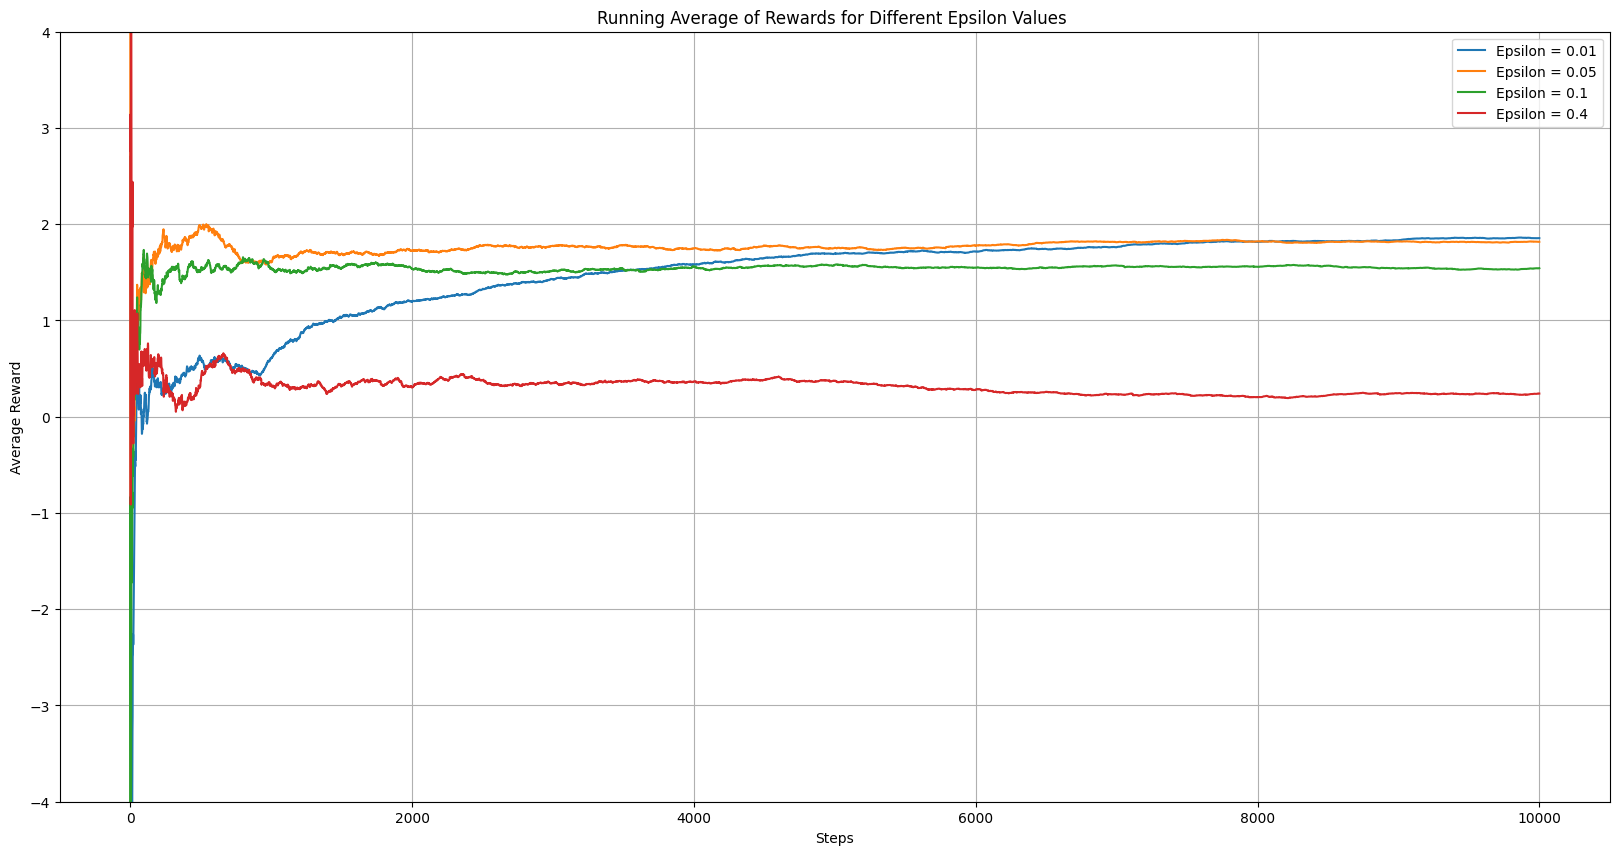

In [7]:
for _ in range(5):
    full_results = []
    for epsilon in epsilon_values:
        all_runs_results = []
        for i in range(num_runs):
            results, individual_score_history = run_sim(steps, epsilon)
            all_runs_results.append(individual_score_history)
            # if i == 0:
                # plot_individual_machines(results, f"example run epsilon {epsilon}")
        
        all_runs_results = np.array(all_runs_results)
        average_scores = np.mean(all_runs_results, axis=0)
        full_results.append(average_scores)
    
    plot_running_average_epsilon(full_results, epsilon_values)

In [8]:
def update_record_history(outcome, record_history, machine):
    alpha, beta = record_history[machine]
    if outcome == 'win':
        alpha += 1
    elif outcome == 'loss':
        beta += 1

    record_history[machine] = (alpha, beta)

def sample_machine(record_history, machine):
    alpha_param, beta_param = record_history[machine]
    return beta.rvs(alpha_param, beta_param)

def get_action_thompson(record_history):
    samples = []
    for i in range(20):
        samples.append(sample_machine(record_history, i))

    return np.argmax(samples)
    

def run_sim_thompson(steps):
    record_history = [(1, 1) for _ in range(20)]
    score_history = [[] for _ in range(20)]
    results = []
    individual_score_history = []
    
    for _ in range(steps):
        selected_machine = get_action_thompson(record_history)
        score = get_probabilities()[selected_machine]
        
        if score > 0:
            reward = 1
            update_record_history('win', record_history, selected_machine)
        else:
            reward = 0
            update_record_history('loss', record_history, selected_machine)

        update_score_history(score, score_history, selected_machine)
        results.append(get_current_preds(score_history))
        individual_score_history.append(score)

    running_average_history = compute_running_average(individual_score_history)
    transposed_results = list(map(list, zip(*results)))
    return transposed_results, running_average_history



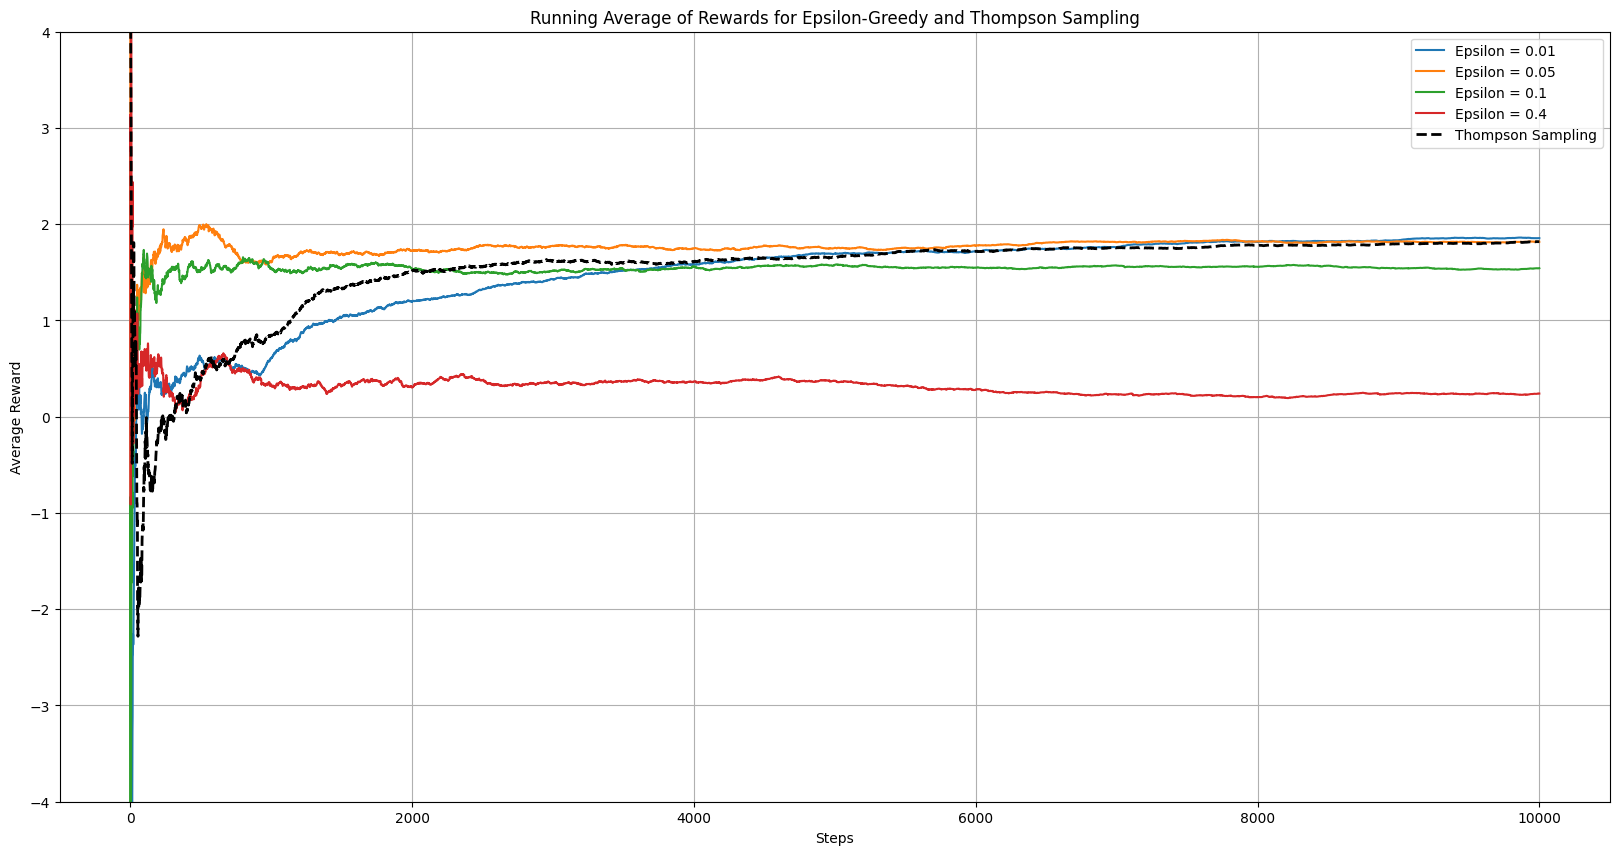

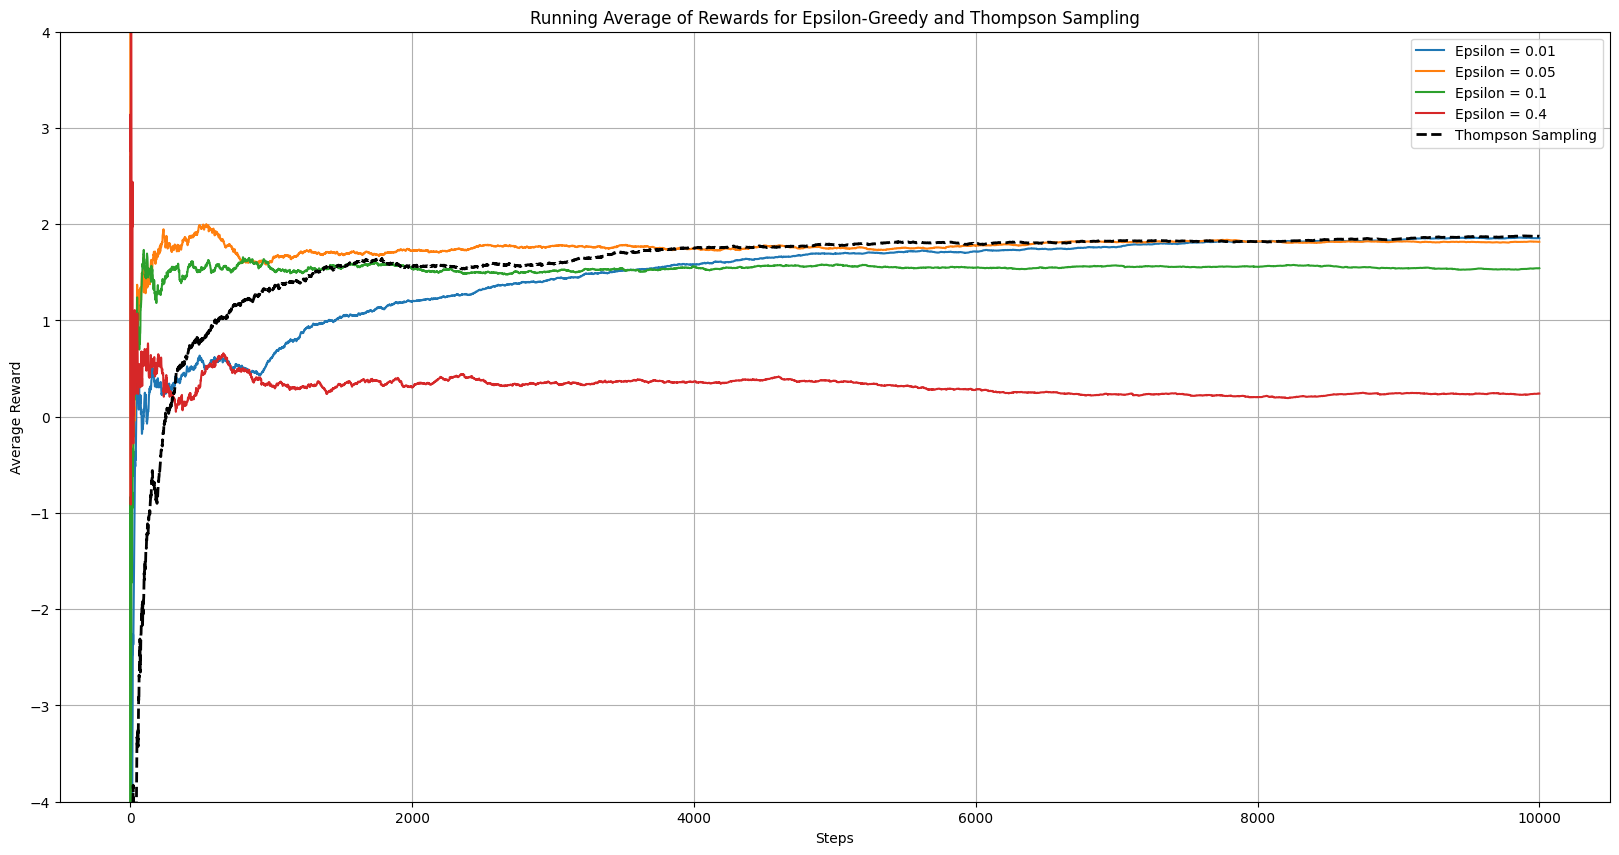

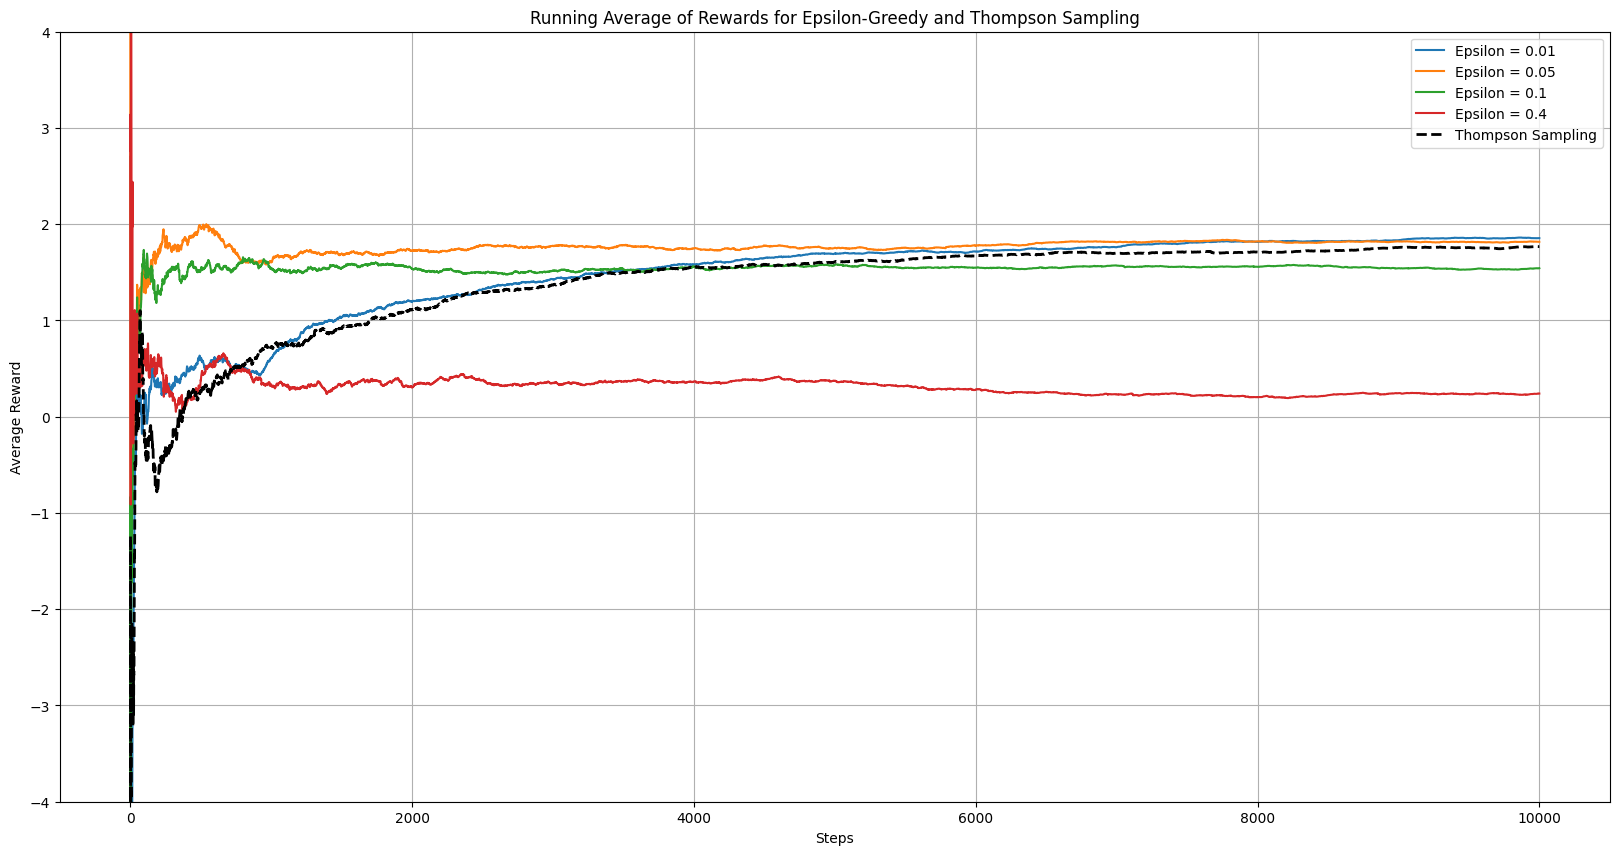

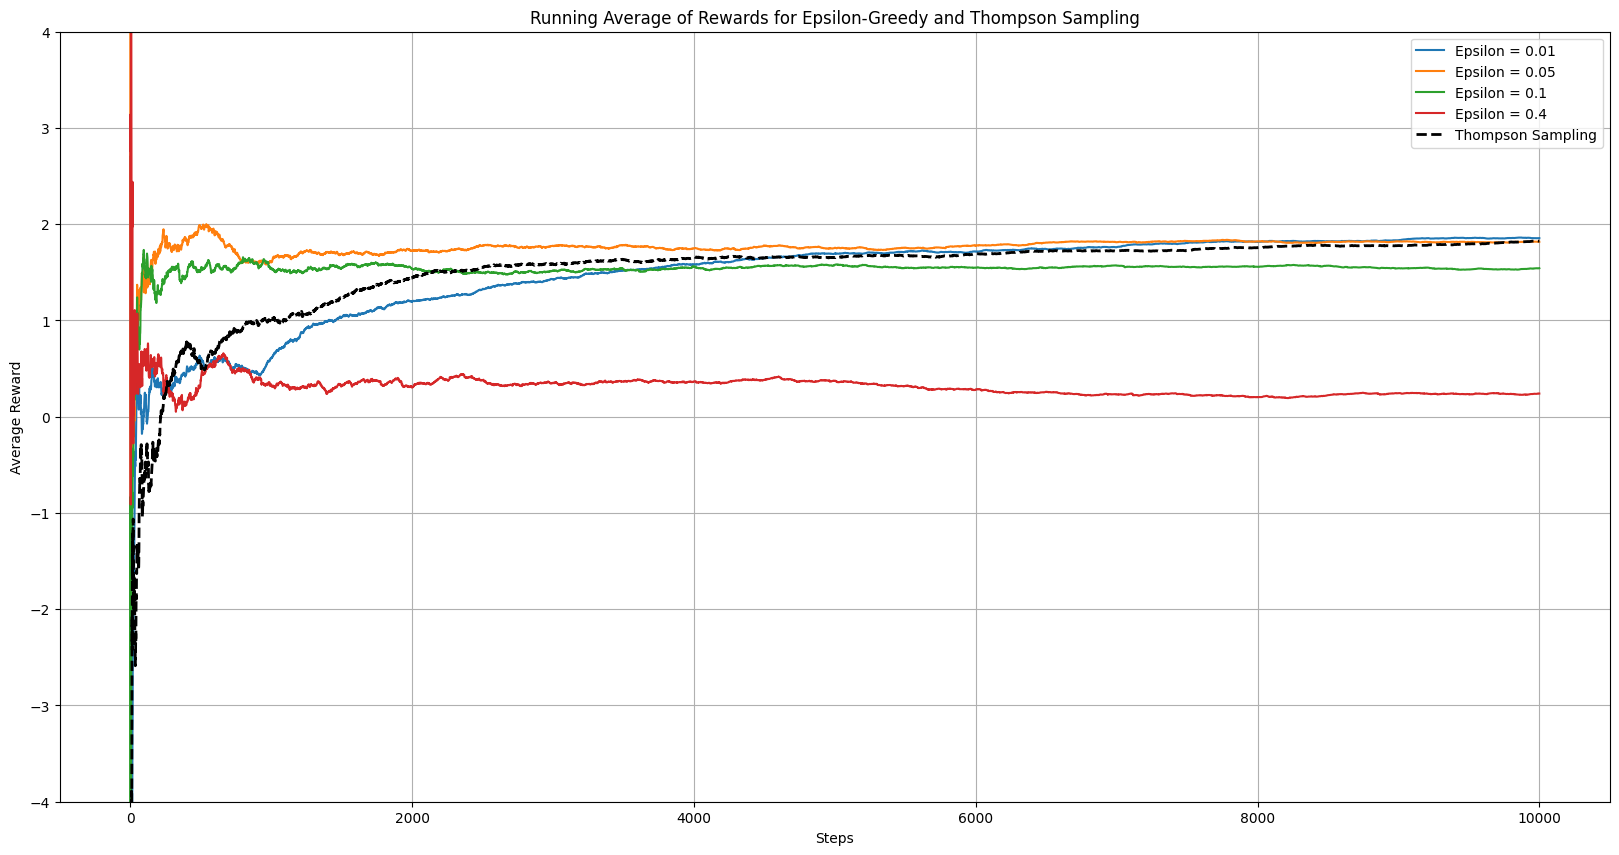

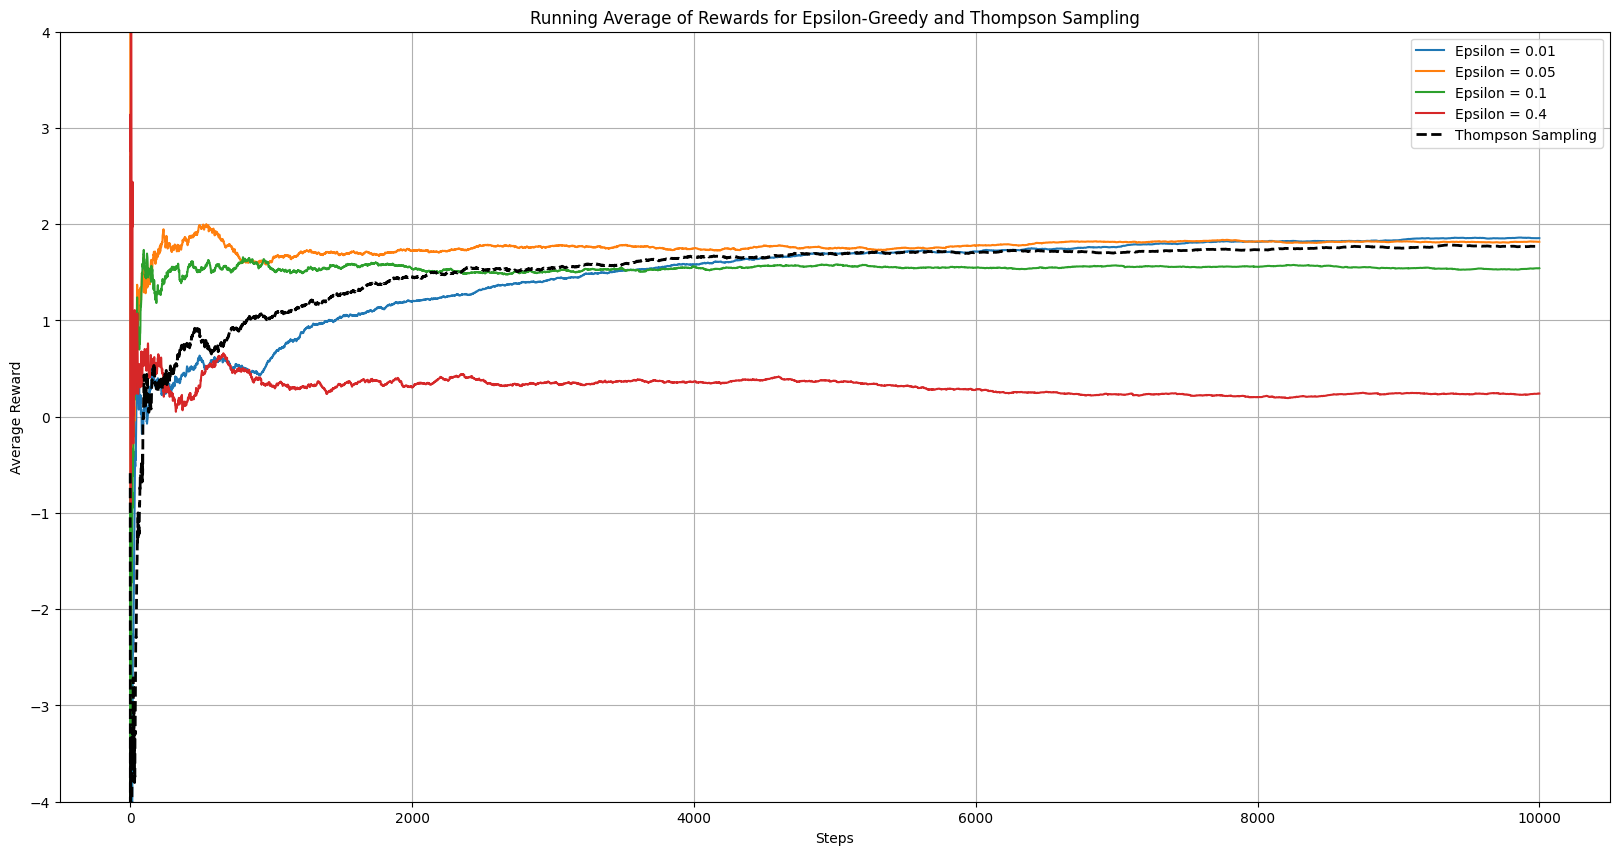

In [9]:
for _ in range(5):
    results_thompson, individual_score_history_thompson = run_sim_thompson(steps)
    plot_running_average_combined(full_results, epsilon_values, individual_score_history_thompson)

In [10]:
def linear_quench(t, total_steps): return max(0, 1 - t / total_steps)

def asymptotic_quench(t, total_steps): return 1 / (1 + 0.01 * t)

def heavy_asymptotic_quench(t, total_steps): return 1 / (1 + 0.0001 * t**2)

In [11]:
def epsilon_greedy_exclude_best(choices, epsilon, current_best):
    if np.random.random() < epsilon:
        return np.random.choice([i for i in range(len(choices)) if i != current_best])
    else:
        return current_best


def weighted_exploration(choices, epsilon, counts):
    if np.random.random() < epsilon:
        unexplored_probs = 1 / (counts + 1)
        return np.random.choice(len(choices), p=unexplored_probs / unexplored_probs.sum())
    else:
        return np.argmax(choices)

In [12]:
def run_sim_quench(steps, quench_type):
    score_history = [[] for _ in range(20)]
    individual_score_history = []
    results = []
    epsilon = 1
    current_step = 1
    
    if (quench_type == "linear"):
        quench_function = linear_quench
    elif (quench_type == "asymptotic"):
        quench_function = asymptotic_quench
    elif (quench_type == "heavy_asymptotic"):
        quench_function = heavy_asymptotic_quench

    for _ in range(steps):
        machine = get_action(epsilon, score_history)
        value = get_probabilities()[machine]
        update_score_history(value, score_history, machine)
        results.append(get_current_preds(score_history))
        individual_score_history.append(value)
        epsilon = quench_function(current_step, steps)
        current_step += 1

    running_average_history = compute_running_average(individual_score_history)
    transposed_results = list(map(list, zip(*results)))
    return transposed_results, running_average_history

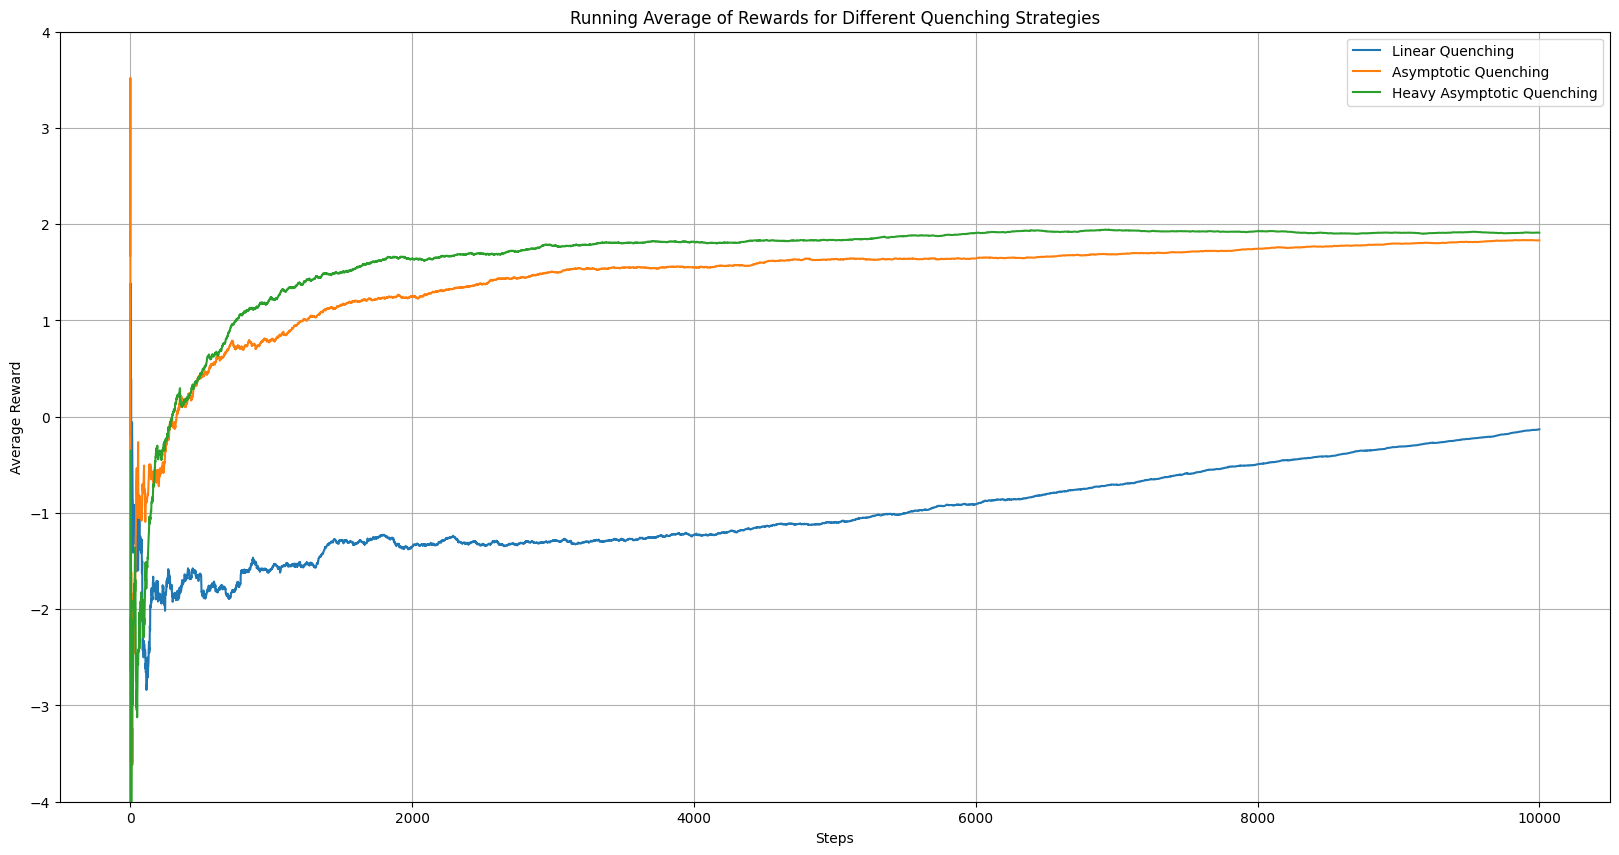

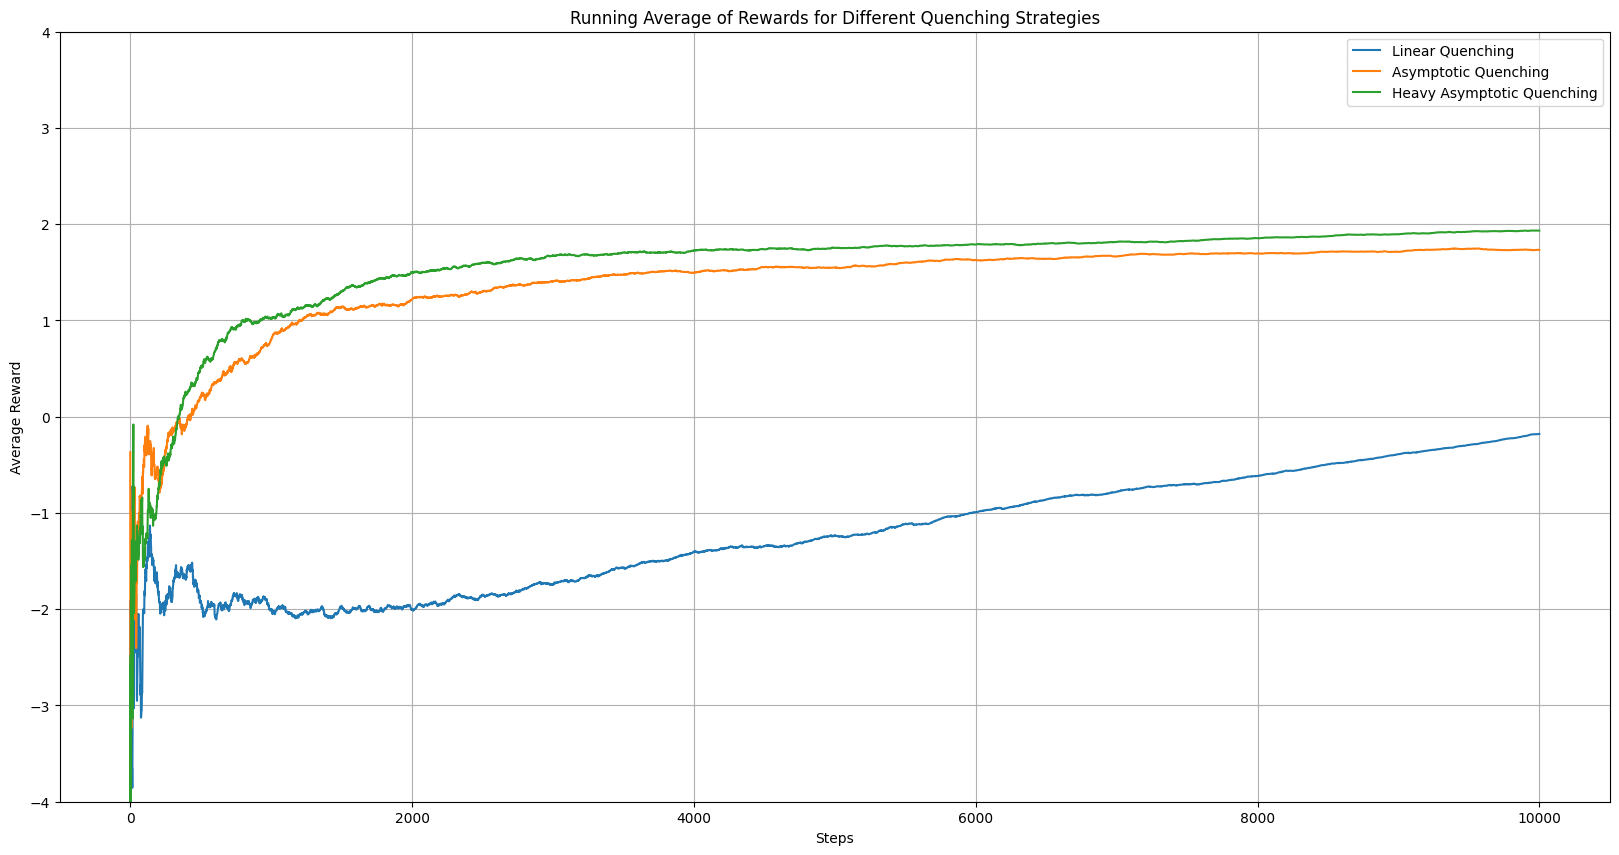

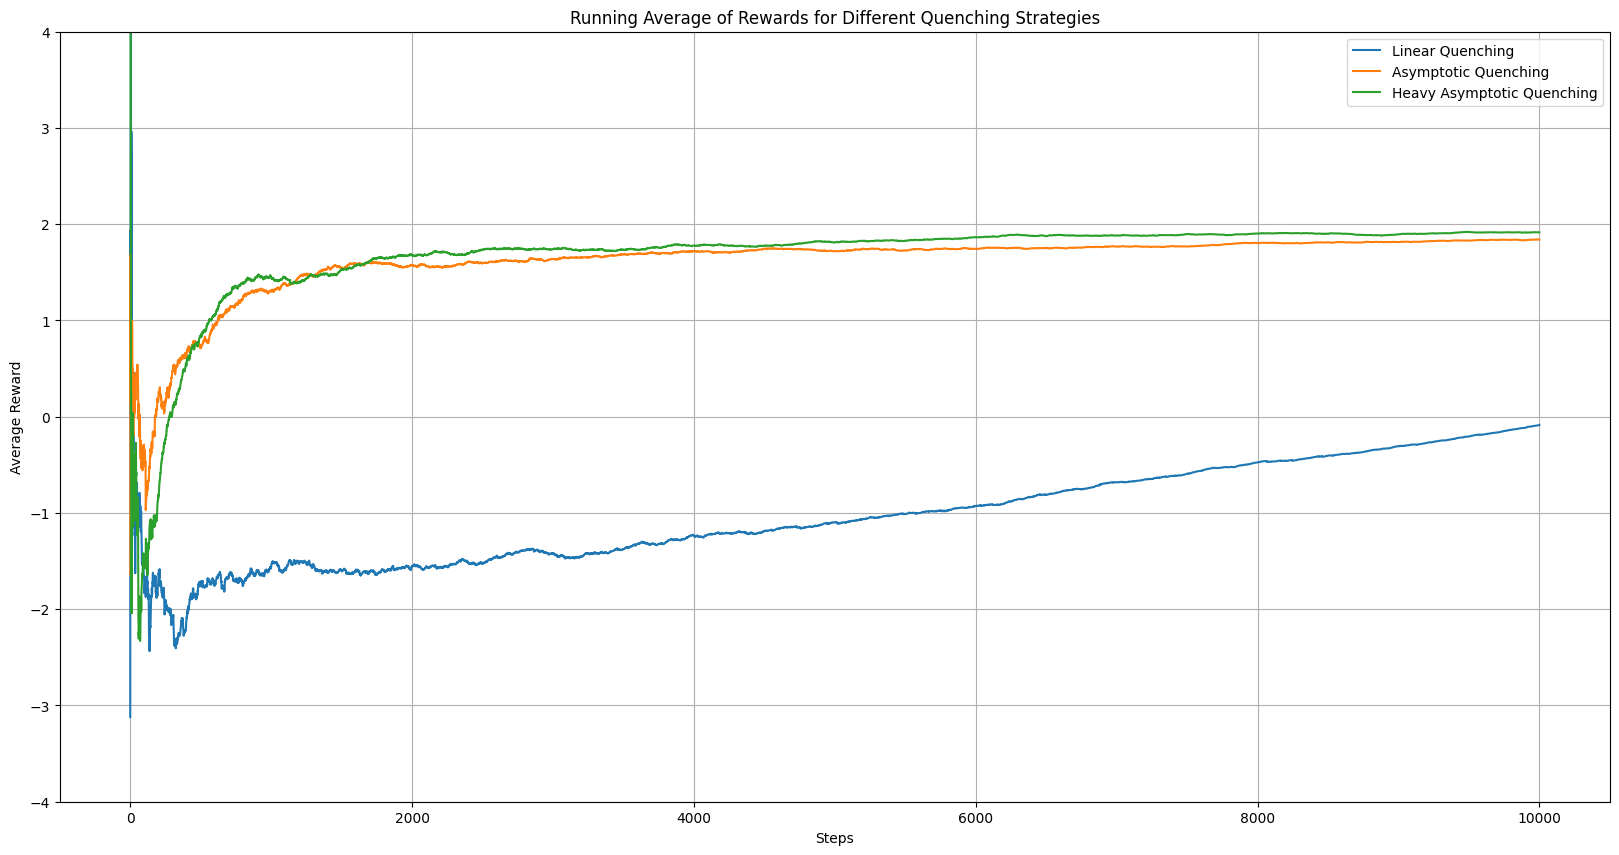

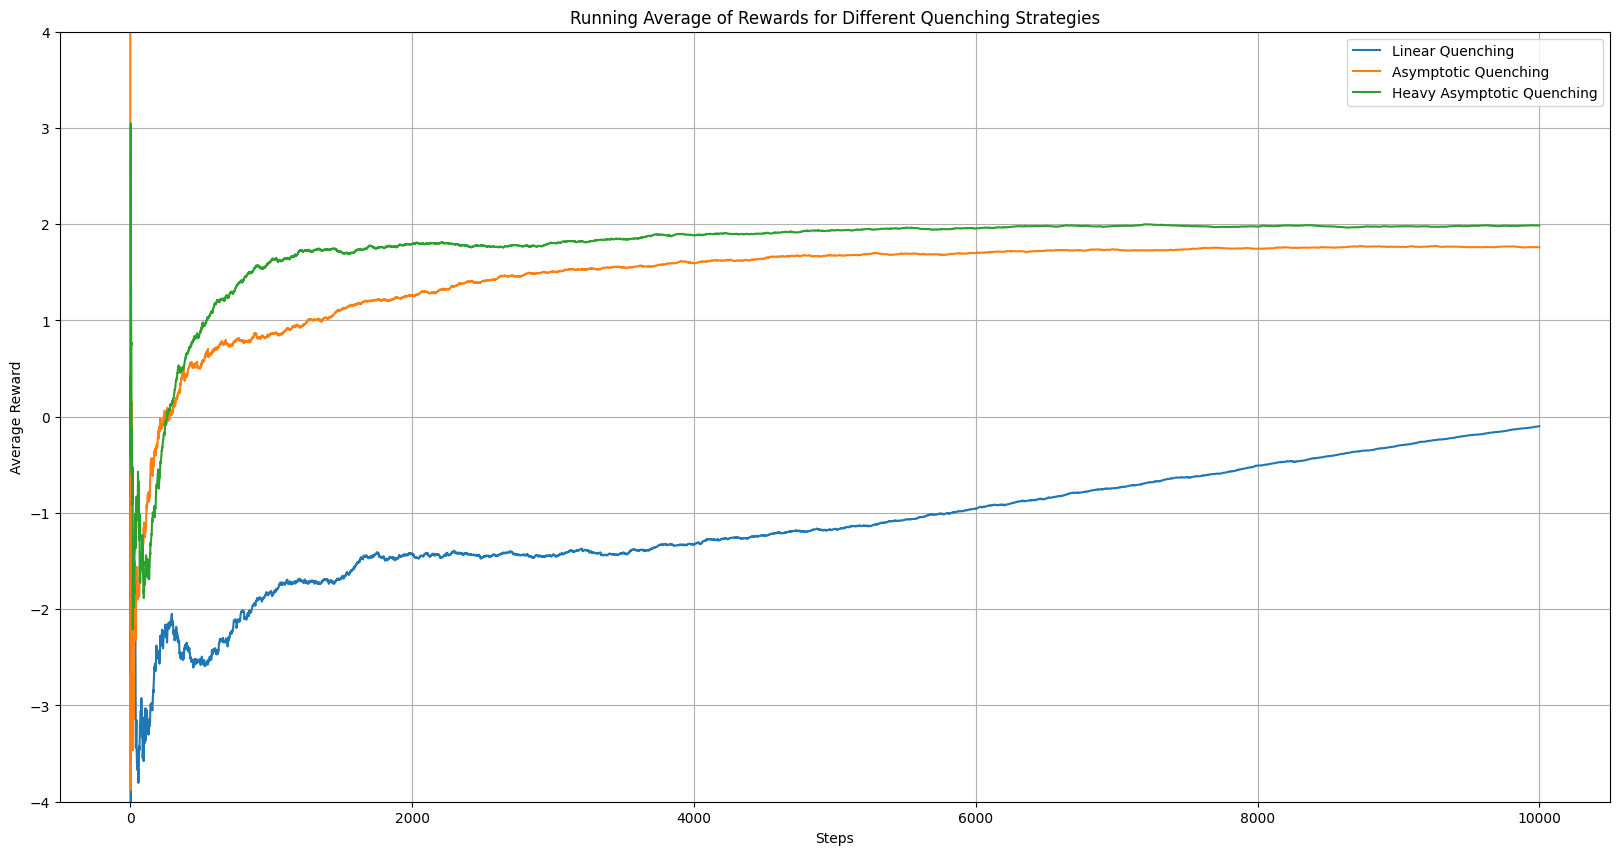

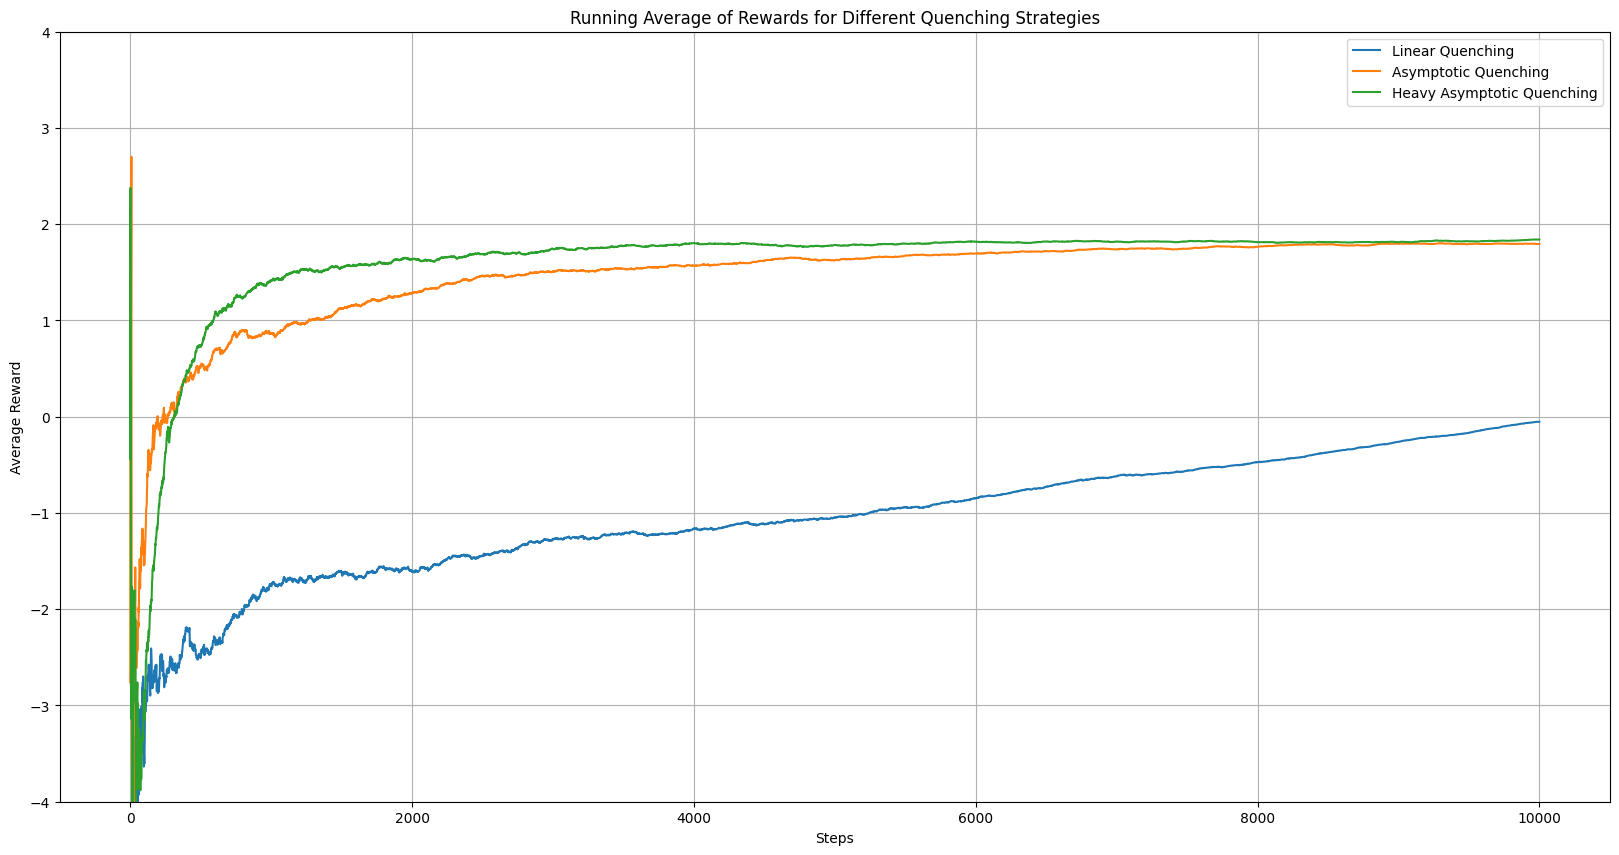

In [13]:
for _ in range(5):
    results_linear, linear_individual_score_history = run_sim_quench(steps, "linear")
    # plot_running_average_x(linear_individual_score_history, 'linear quenching')
    
    results_linear, asymptotic_individual_score_history = run_sim_quench(steps, "asymptotic")
    # plot_running_average_x(asymptotic_individual_score_history, 'asymptotic quenching')
    
    results_linear, heavy_asymptotic_individual_score_history = run_sim_quench(steps, "heavy_asymptotic")
    # plot_running_average_x(heavy_asymptotic_individual_score_history, 'heavy asymptotic quenching')
    
    quenching_results = [
        linear_individual_score_history,
        asymptotic_individual_score_history,
        heavy_asymptotic_individual_score_history
    ]
    
    quenching_labels = ['Linear Quenching', 'Asymptotic Quenching', 'Heavy Asymptotic Quenching']
    plot_quenching_strategies(quenching_results, quenching_labels)

In [14]:
def epsilon_greedy_exclude_best(epsilon, score_history):
    current_preds = get_current_preds(score_history)
    best_machine = max(range(len(current_preds)), key=lambda i: current_preds[i])
    if random.random() > epsilon:
        return best_machine
    else:
        choices = [i for i in range(len(current_preds)) if i != best_machine]
        return random.choice(choices)

def weighted_exploration(epsilon, score_history):
    current_preds = get_current_preds(score_history)
    best_machine = max(range(len(current_preds)), key=lambda i: current_preds[i])
    counts = get_machine_counts(score_history)
    if random.random() > epsilon:
        return best_machine
    else:
        unexplored_probs = 1 / (np.array(counts) + 1)
        return np.random.choice(len(score_history), p=unexplored_probs / unexplored_probs.sum())

In [15]:
def run_sim_exclude_best(steps, epsilon):
    score_history = [[] for _ in range(20)]
    individual_score_history = []
    results = []
    for _ in range(steps):
        machine = epsilon_greedy_exclude_best(epsilon, score_history)
        value = get_probabilities()[machine]
        update_score_history(value, score_history, machine)
        results.append(get_current_preds(score_history))
        individual_score_history.append(value)

    running_average_history = compute_running_average(individual_score_history)
    transposed_results = list(map(list, zip(*results)))
    return transposed_results, running_average_history

def run_sim_weighted_exploration(steps, epsilon):
    score_history = [[] for _ in range(20)]
    individual_score_history = []
    results = []
    for _ in range(steps):
        machine = weighted_exploration(epsilon, score_history)
        value = get_probabilities()[machine]
        update_score_history(value, score_history, machine)
        results.append(get_current_preds(score_history))
        individual_score_history.append(value)

    running_average_history = compute_running_average(individual_score_history)
    transposed_results = list(map(list, zip(*results)))
    return transposed_results, running_average_history

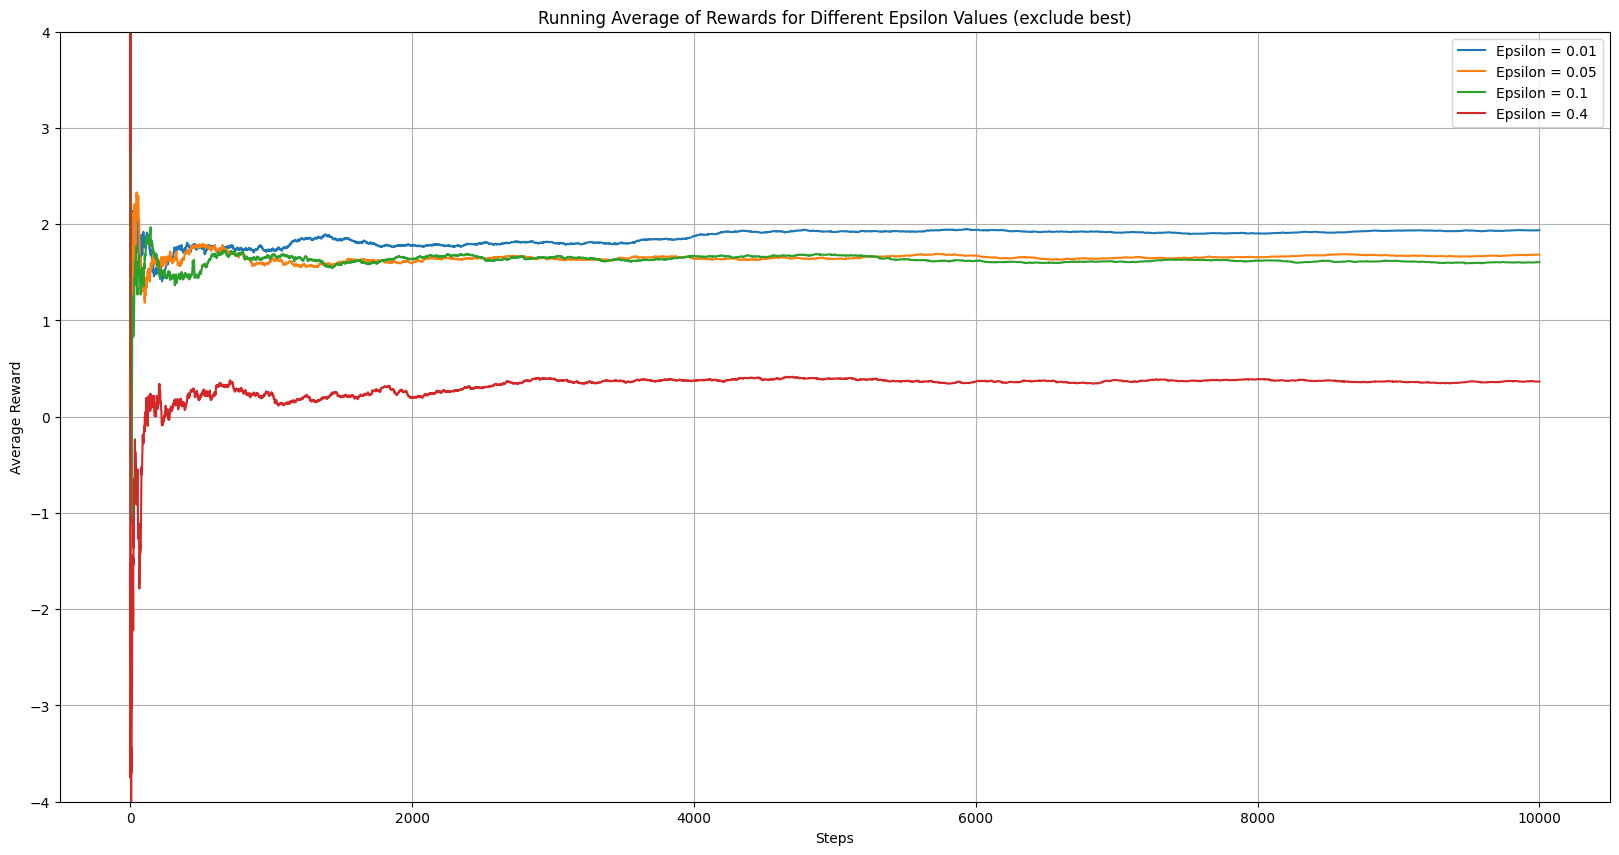

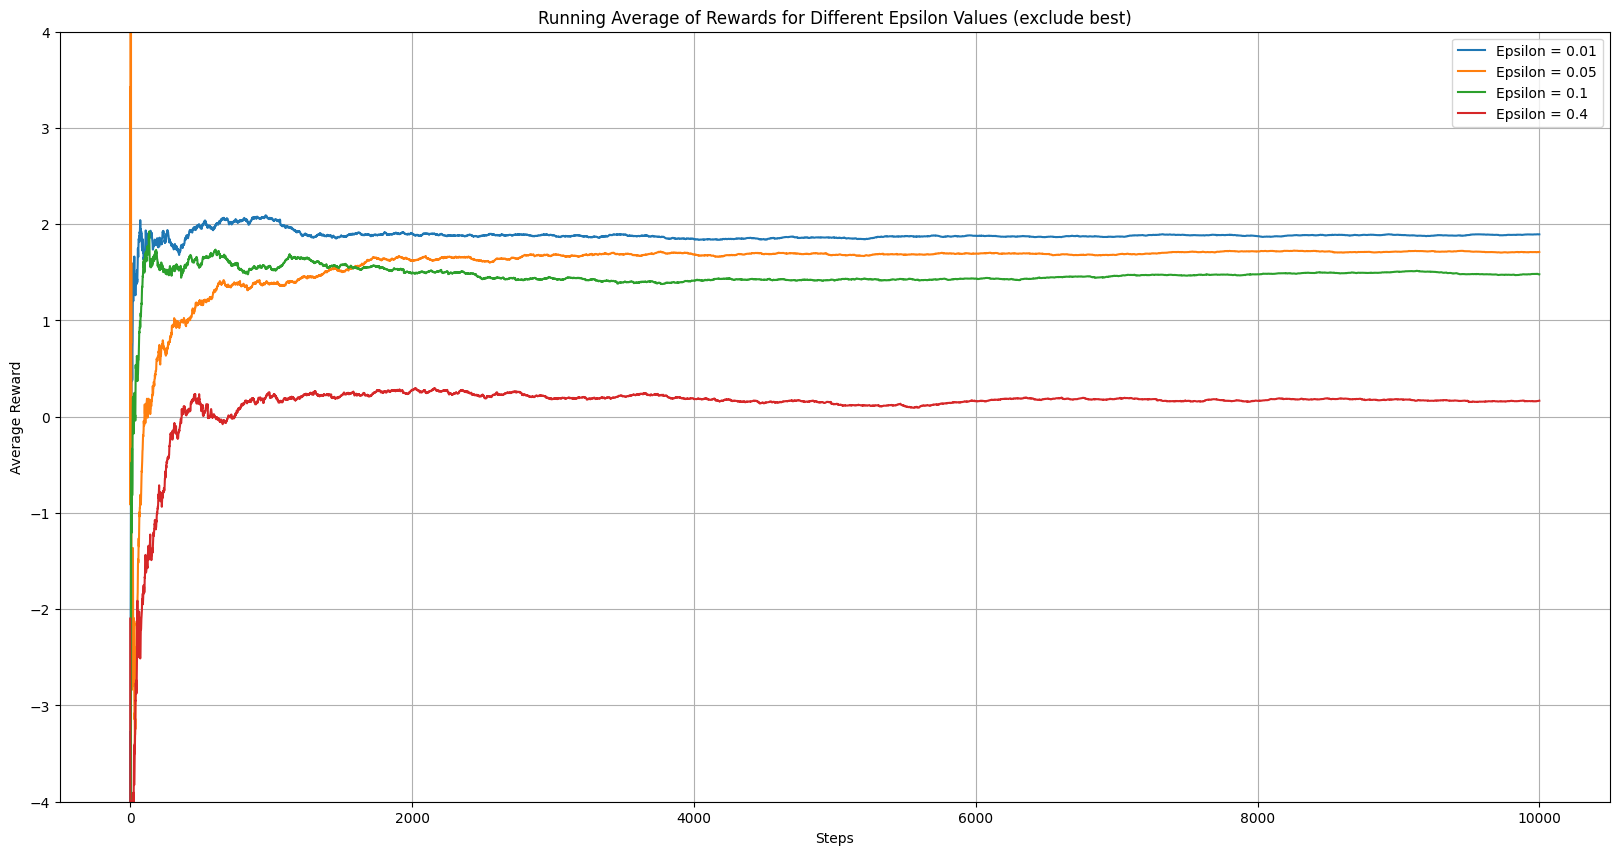

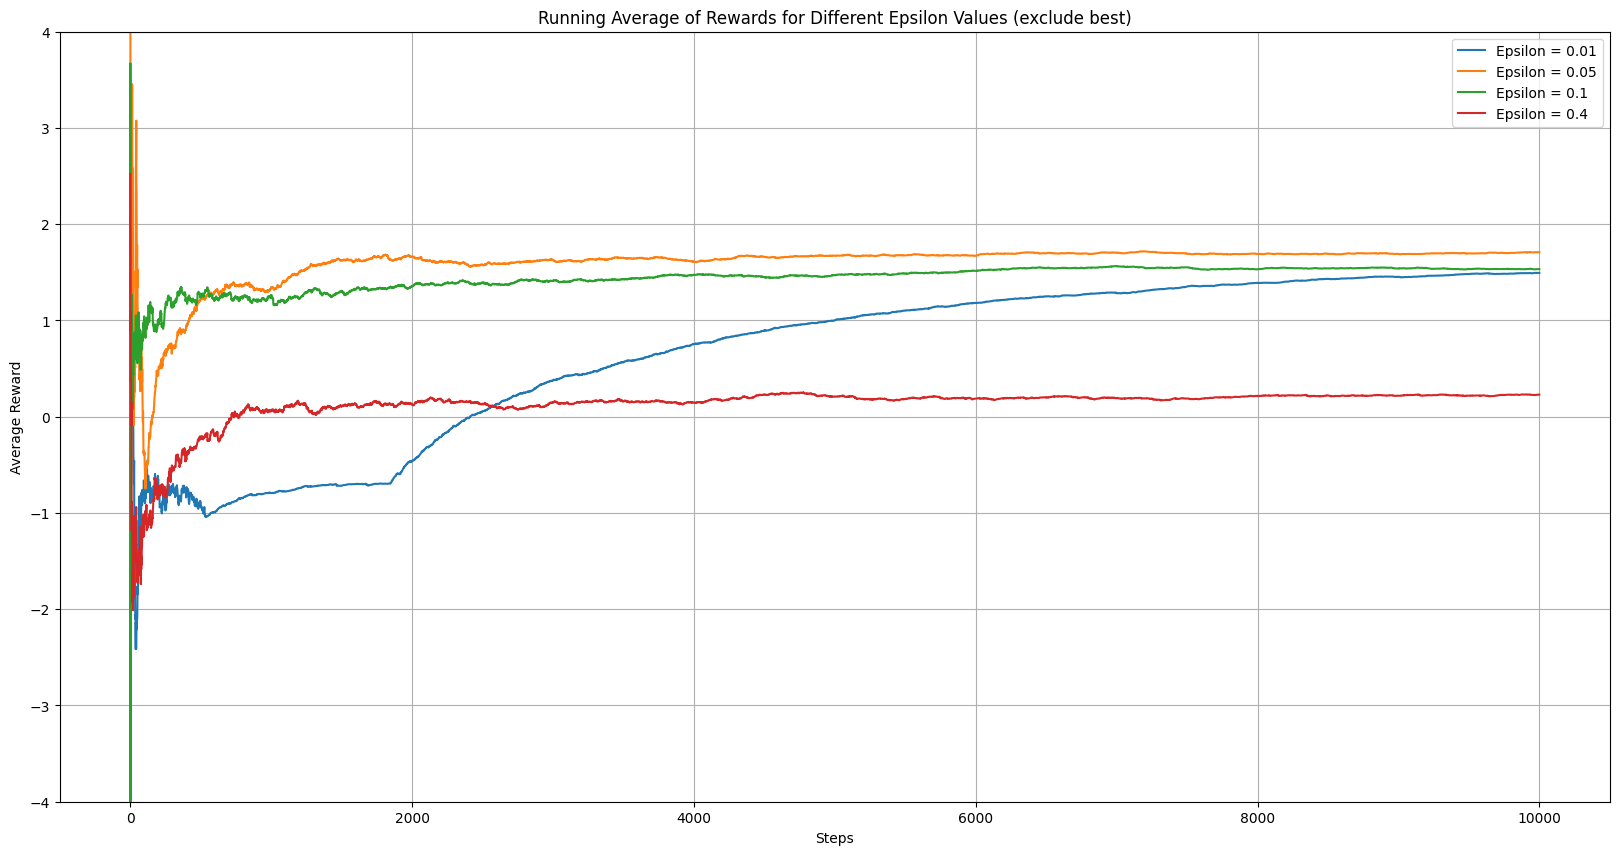

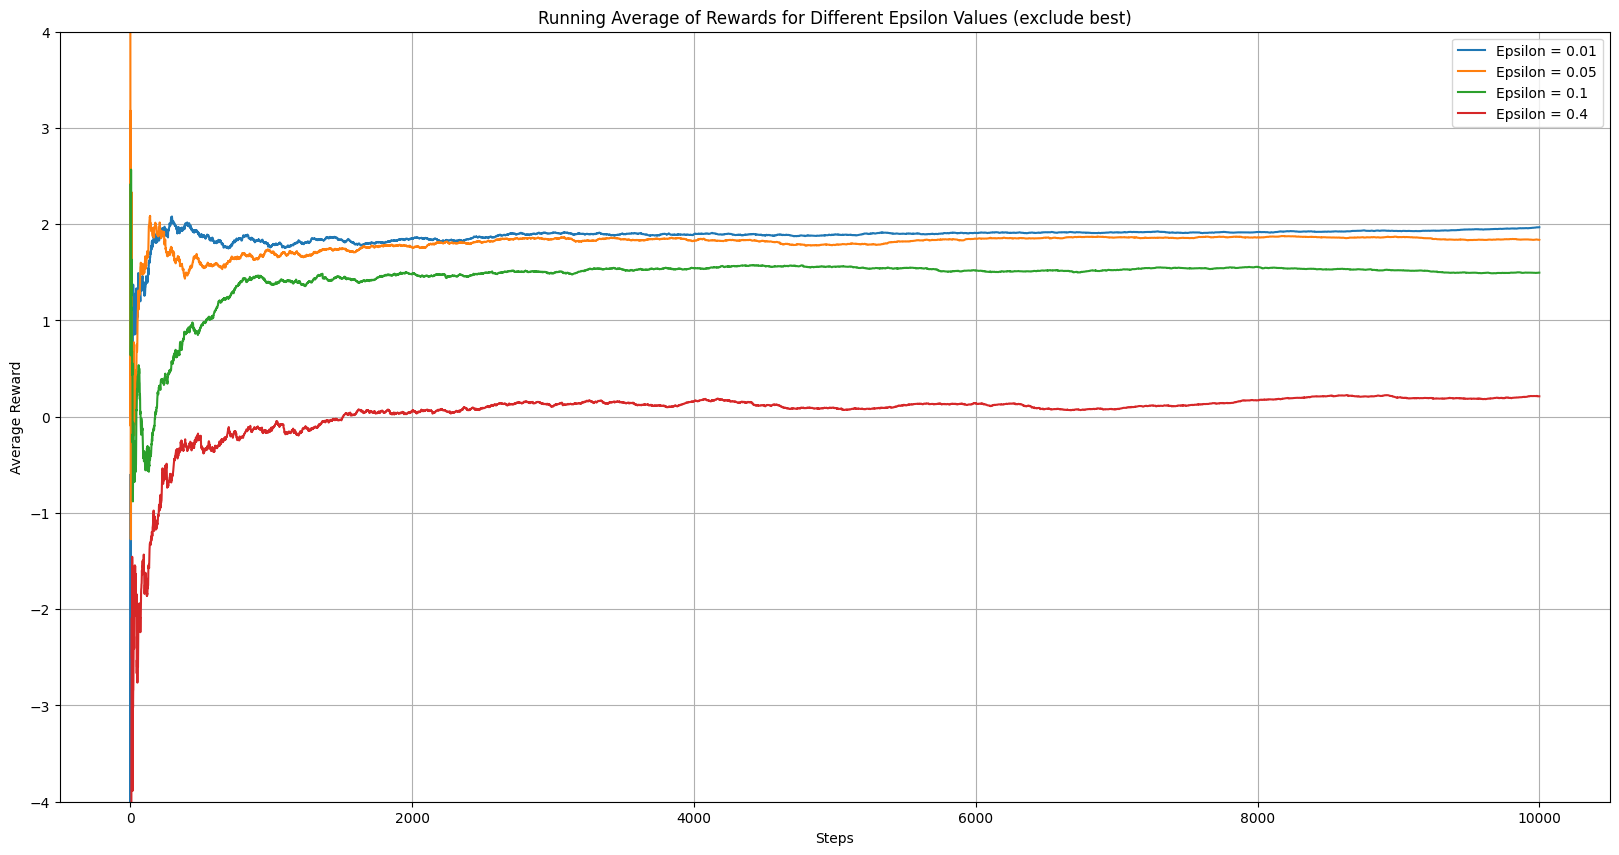

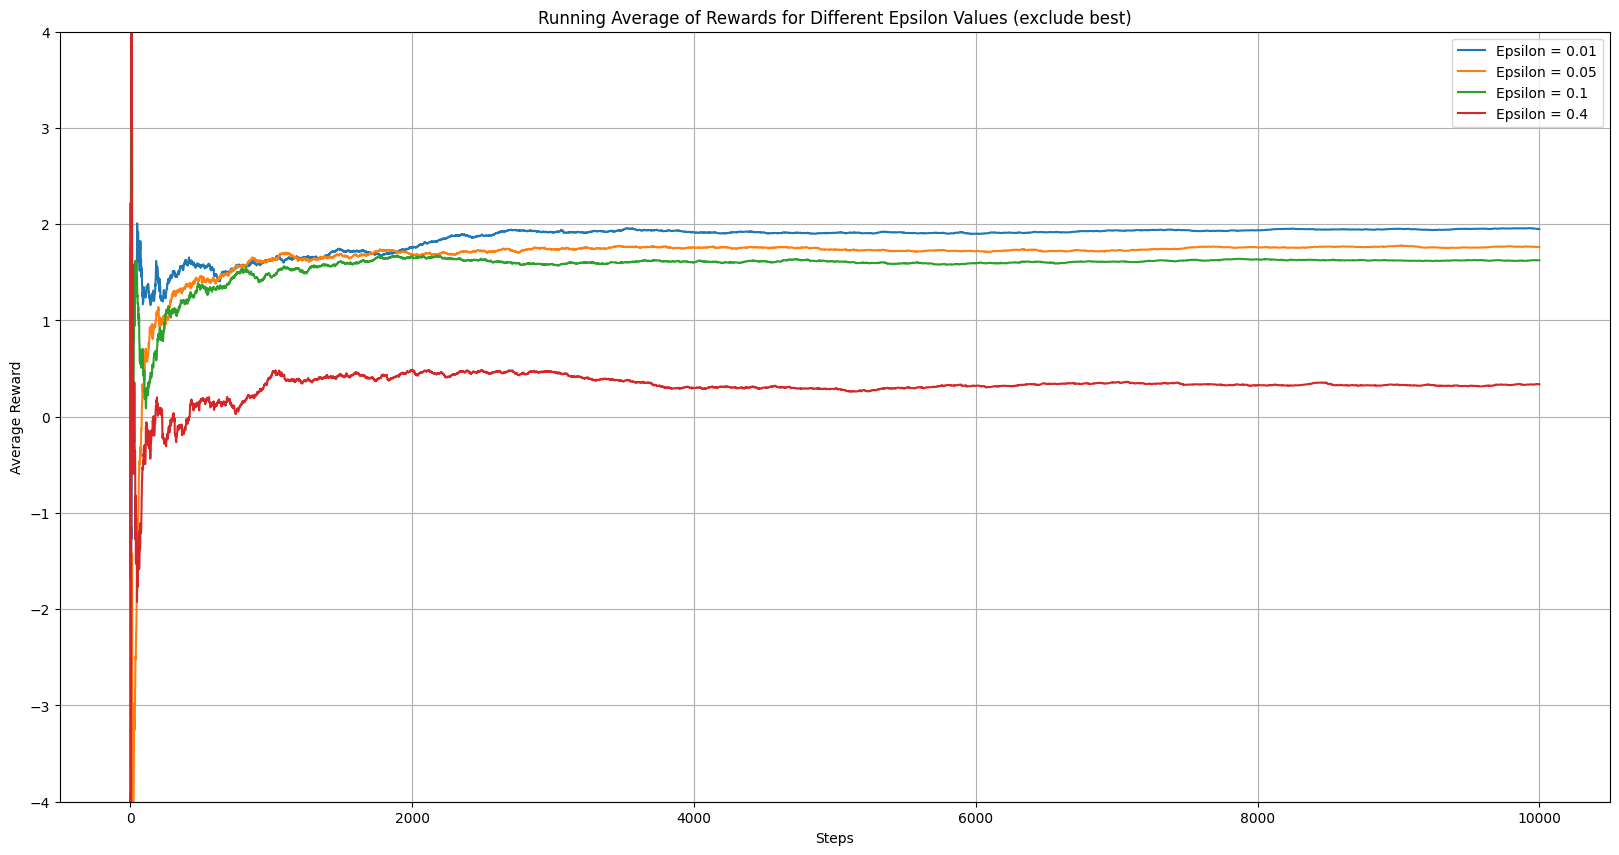

In [16]:
for _ in range(5):
    full_results = []
    for epsilon in epsilon_values:
        all_runs_results = []
        for i in range(num_runs):
            results, individual_score_history = run_sim_exclude_best(steps, epsilon)
            all_runs_results.append(individual_score_history)
            # if i == 0:
            #     plot_individual_machines(results, f"example run (exclude best) epsilon {epsilon}")
        
        all_runs_results = np.array(all_runs_results)
        average_scores = np.mean(all_runs_results, axis=0)
        full_results.append(average_scores)
    
    plot_running_average_epsilon(full_results, epsilon_values, "(exclude best)")

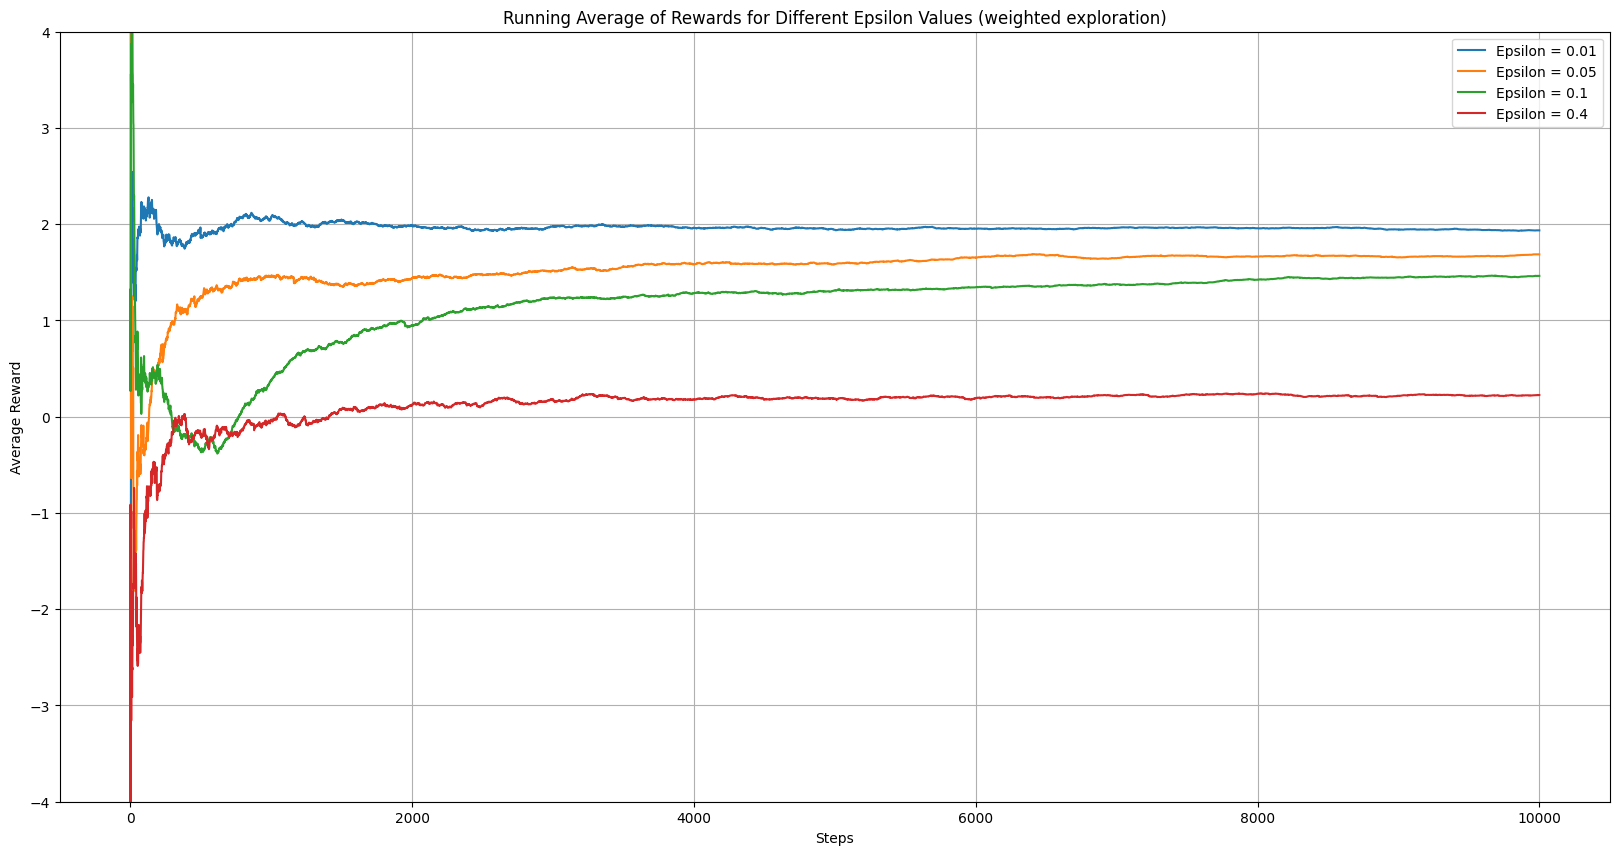

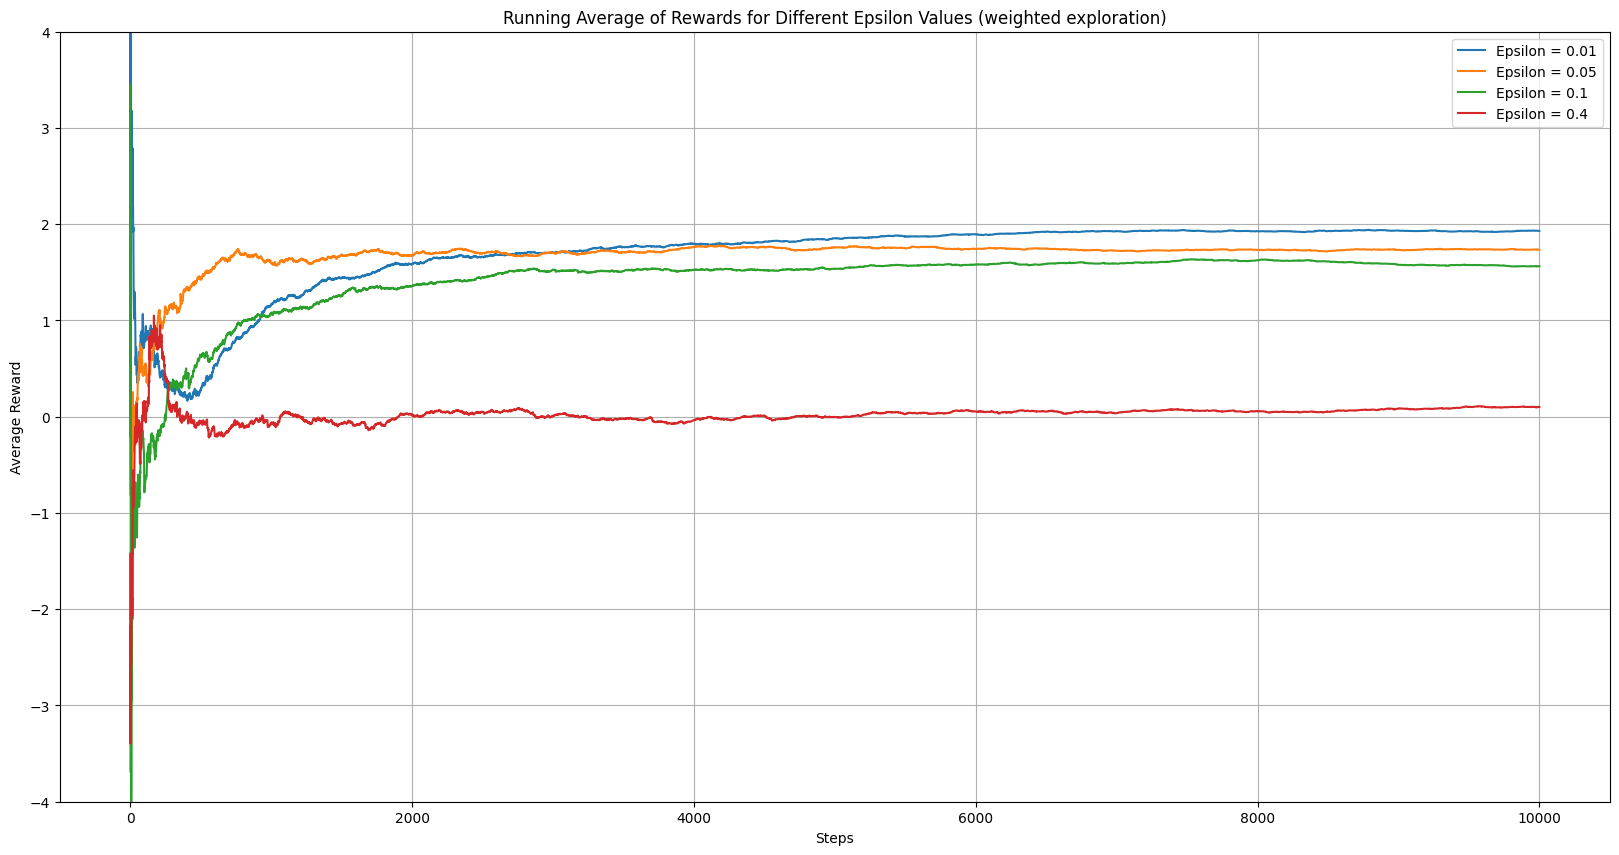

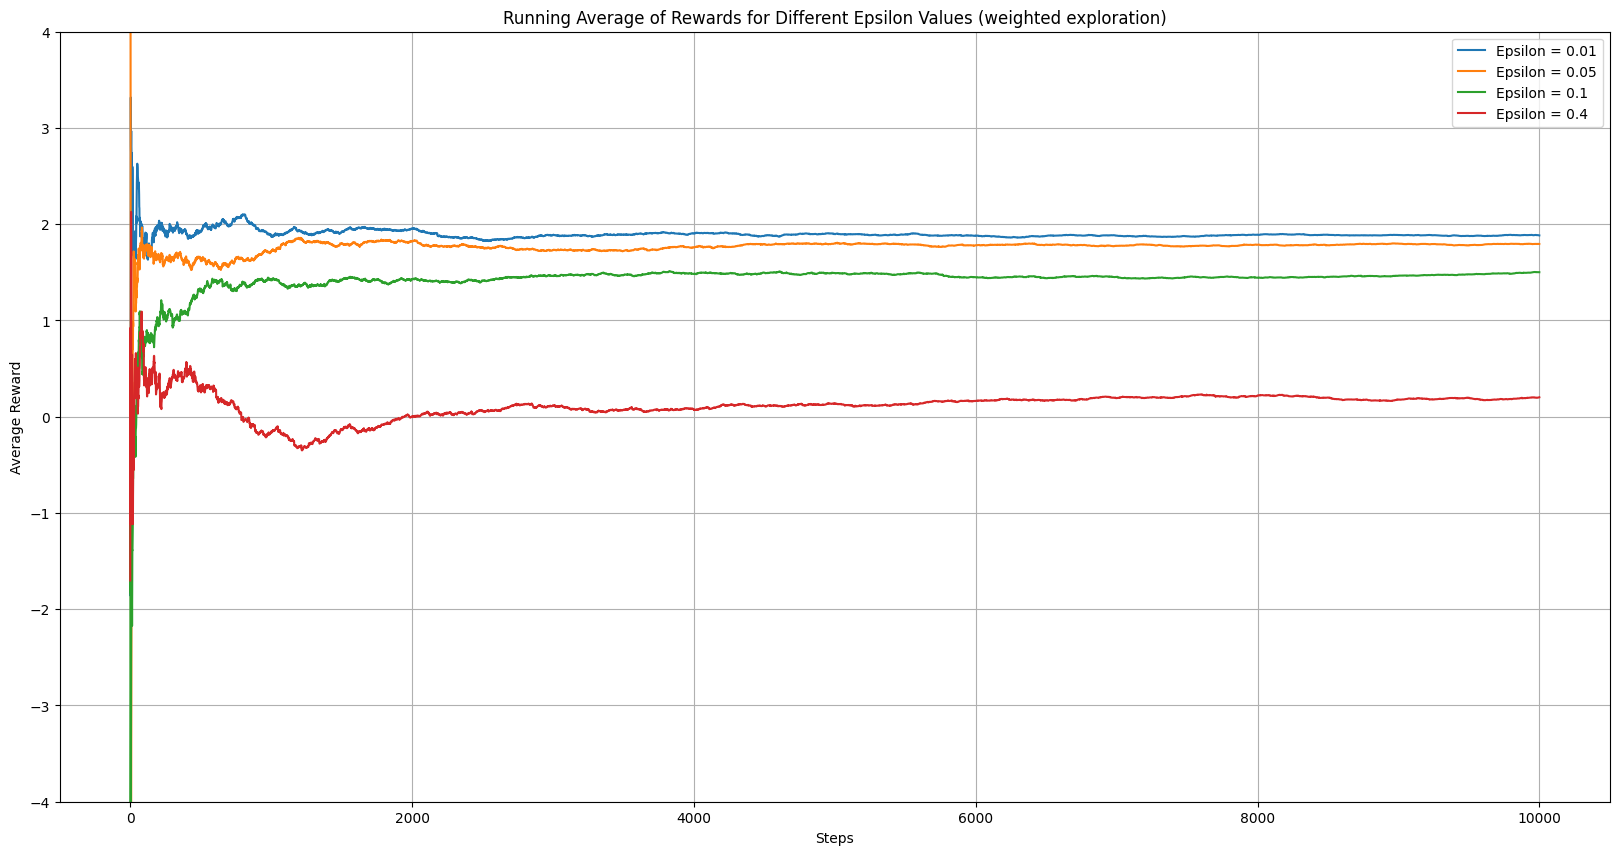

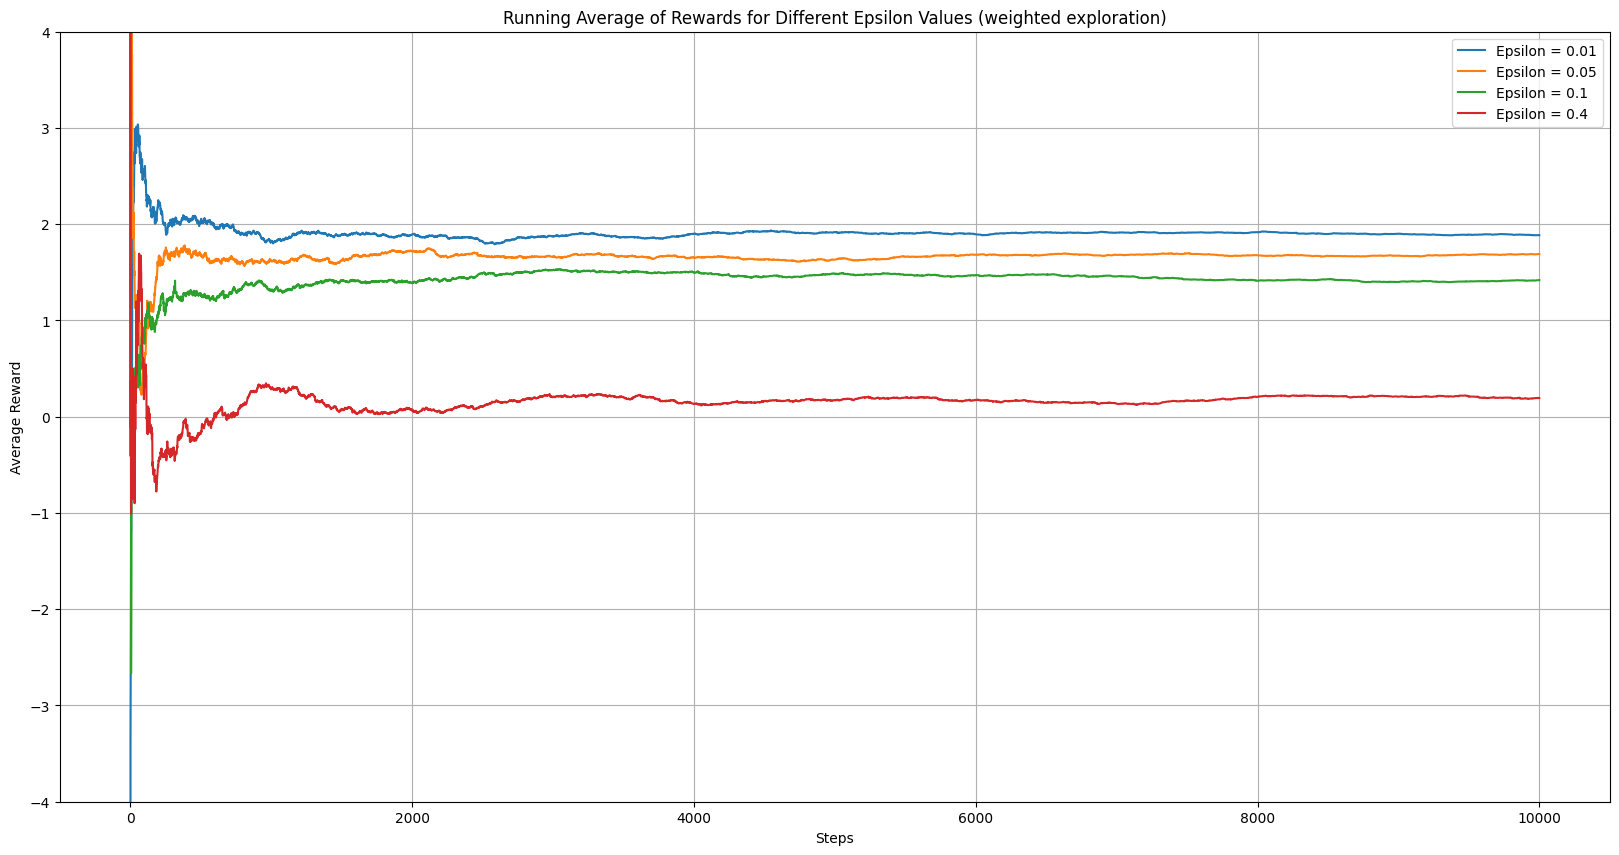

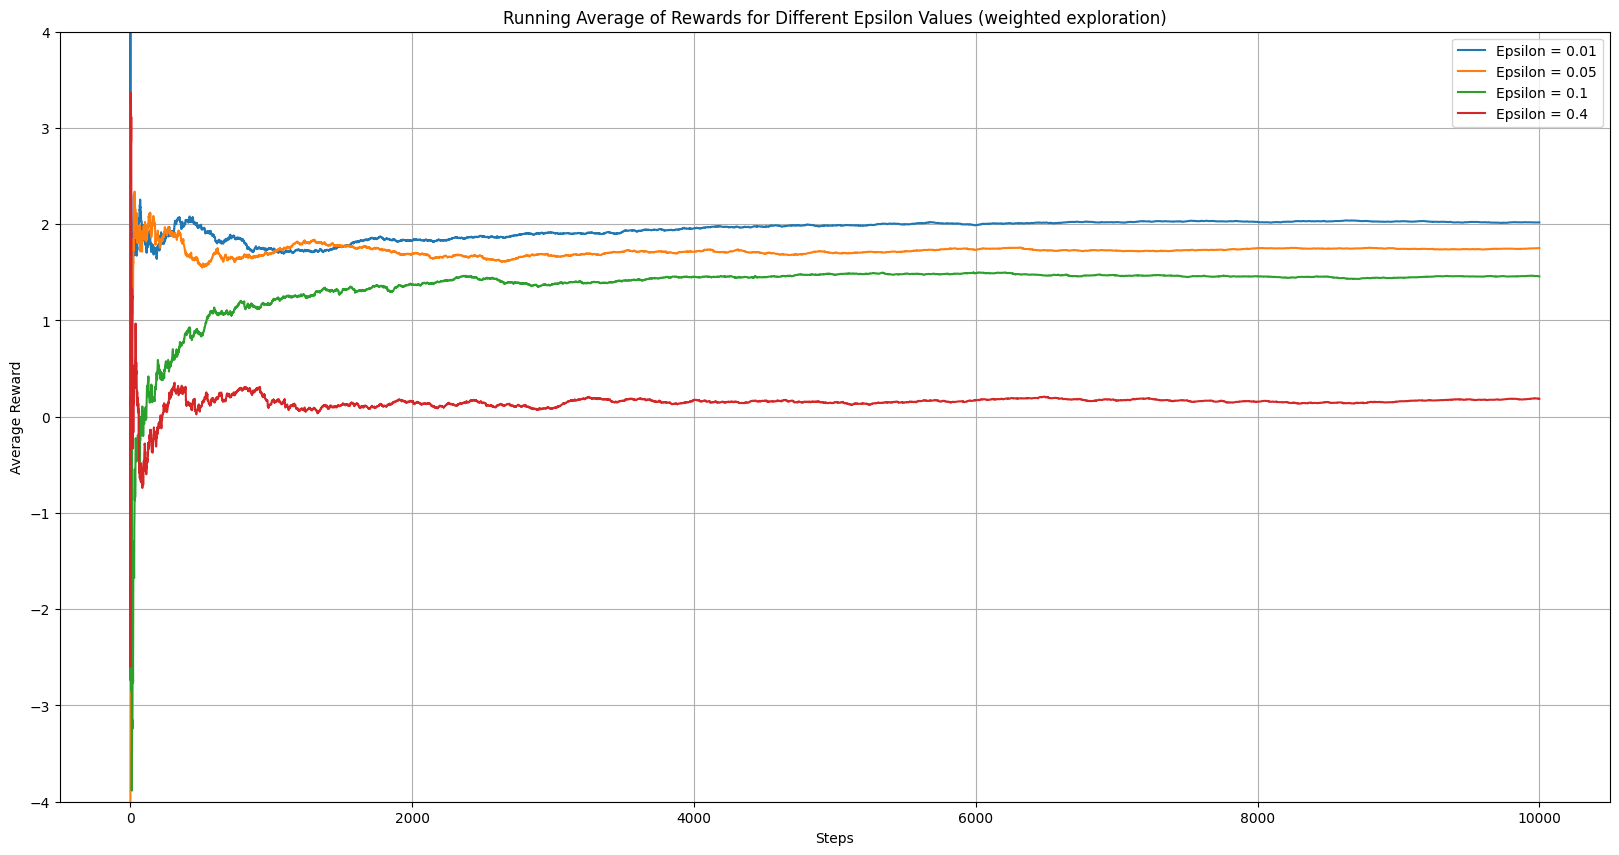

In [17]:
for _ in range(5):
    full_results = []
    for epsilon in epsilon_values:
        all_runs_results = []
        for i in range(num_runs):
            results, individual_score_history = run_sim_weighted_exploration(steps, epsilon)
            all_runs_results.append(individual_score_history)
            # if i == 0:
            #     plot_individual_machines(results, f"example run (weighted exploration) epsilon {epsilon}")
        
        all_runs_results = np.array(all_runs_results)
        average_scores = np.mean(all_runs_results, axis=0)
        full_results.append(average_scores)
    
    plot_running_average_epsilon(full_results, epsilon_values, "(weighted exploration)")